In [1]:
! pip install pretty_midi

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for mido>=1.1.16 from https://files.pythonhosted.org/packages/39/2c/df005c4b310dde2c834431032139bf2c3924f81798013feb052d1afd543b/mido-1.3.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592288 sha256=c245d145df76ba4d1bc308e943d53fb02f6135bee01f3960a941d0bbea1b4ce0
  Stored in directory: /sise/home/ronyshi/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [4]:
! pip install gensim

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for FuzzyTM>=0.4.0 from https://files.pythonhosted.org/packages/2d/30/074bac7a25866a2807c1005c7852c0139ac22ba837871fc01f16df29b9dc/FuzzyTM-2.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for pyfume from https://files.pythonhosted.org/packages/ed/ea/a3b120e251145dcdb10777f2bc5f18b1496fd999d705a178c1b0ad947ce1/pyFUME-0.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.7.0 from https://files.pythonhosted.org/packages/21/cd/fe2d4af234b80dc08c911ce63fdaee5badcdde3e9bcd9a68884580652ef0/scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 670.2 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for numpy>=1.18.5 from https://files.pythonhosted.org/packages/22/97/dfb1a31bb46686f09e68ea6ac5c63fdee0d22d7b23b8f3f7ea07712869ef/numpy-1.24.4-cp311-

In [5]:
! pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
! pip install tensorboard tensorflow

In [57]:
! pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 2.8 MB/s eta 0:00:0000:0100:01


In [2]:
! pip install python-Levenshtein

In [98]:
import pandas as pd
import pretty_midi
import gensim.downloader as api
from sklearn.preprocessing import MinMaxScaler
import os
from os.path import isfile, join
from tqdm import tqdm
from torch.utils.data import SubsetRandomSampler, DataLoader
import string
import re
import nltk
import torch
from torch.utils.data import Dataset
from nltk.corpus import stopwords
import pickle
nltk.download('stopwords')
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
import itertools
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import Levenshtein
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kirmayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# -----------------------------------------------------------------------------------------------

# Pre-Process

## W2V

In [21]:
word2vec_model = api.load("word2vec-google-news-300")

## PreProcess - First Approach

In [23]:

def get_midi_data(directory_path):
    '''
    Extract melody features from MIDI files in the given directory.

    Parameters:
    - directory_path (str): Path to the directory containing MIDI files.

    Returns:
    - features_dict (dict): A dictionary containing extracted features for each song.
    - num_of_melody_features (int): Number of melody features extracted for each song.
    '''
    files = [file for file in os.listdir(directory_path) if isfile(join(directory_path, file))]
    features_dict = {}
    num_of_melody_features = 12
    for filename in tqdm(files, desc="Extracting features"):
        try:
            singer_name, song_name = filename.replace('.mid', '').split("_-_")
            singer_name = " ".join(singer_name.split("_")).lower()
            song_name = " ".join(song_name.split("_")).lower()
        except ValueError:
            print(f"Skipping file {filename}: cannot parse singer and song name")
            continue

        try:
            midi_data = pretty_midi.PrettyMIDI(join(directory_path, filename))
            melody_features= np.zeros(12)
            tempo_changes, tempi = midi_data.get_tempo_changes()
            chroma = midi_data.get_chroma()
            song_velocity = np.sum(chroma)
            song_semitones = [np.sum(semitone) / song_velocity for semitone in chroma] if song_velocity else np.zeros(chroma.shape[0])

            melody_features = np.array([
                len(tempo_changes),
                np.mean(tempi),
                np.var(tempi),
                np.max(tempi),
                np.min(tempi),
                np.median(tempi),
                len(song_semitones),
                np.mean(song_semitones),
                np.var(song_semitones),
                np.max(song_semitones),
                np.min(song_semitones),
                np.median(song_semitones),
            ])


        except Exception as e:
            print(f"Error processing {filename}: {e}")
            melody_features = np.zeros(num_of_melody_features)

        features_dict[(singer_name, song_name)] = melody_features
        #features_dict[(singer_name, song_name)] = all_features


    print(f"Extracted melody features for {len(features_dict)} songs.")
    return features_dict, num_of_melody_features


In [24]:
def normalize_features(features_dict):
    """
    Normalize the features with MinMaxScaler in the given features dictionary.

    Parameters:
    - features_dict (dict): A dictionary containing the features.

    Returns:
    - normalized_features_dict (dict): A dictionary containing the normalized features.
    """
    
    feature_matrix = np.array(list(features_dict.values()))
    scaler = MinMaxScaler()
    normalized_matrix = scaler.fit_transform(feature_matrix)
    normalized_features_dict = {song: features for song, features in zip(features_dict.keys(), normalized_matrix)}
    return normalized_features_dict


def get_features(singer_name, song_name, normalized_features_dictionary):
    """
    Get the normalized features for a given singer and song name.

    Parameters:
    - singer_name (str): The name of the singer.
    - song_name (str): The name of the song.
    - normalized_features_dictionary (dict): A dictionary containing the normalized features.

    Returns:
    - features (array-like): The normalized features for the given singer and song name, or "Features not found" if not found.
    """
    key = (singer_name.lower().strip(), song_name.lower().strip())
    return normalized_features_dictionary.get(key, "Features not found")

In [25]:
features_dictionary, num_of_features = get_midi_data('midi_files')
normalized_features_dictionary= normalize_features(features_dictionary)

Extracting features:   1%|▏         | 8/625 [00:02<02:36,  3.94it/s]/home/kirmayer/.conda/envs/my_env/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting features:   3%|▎         | 17/625 [00:03<01:50,  5.51it/s]

Error processing Aaron_Neville_-_Tell_It_Like_It_Is.mid: data byte must be in range 0..127


Extracting features:  20%|█▉        | 124/625 [00:24<01:03,  7.88it/s]

Error processing Beastie_Boys_-_Girls.mid: Could not decode key with 1 flats and mode 255


Extracting features:  27%|██▋       | 170/625 [00:33<00:53,  8.58it/s]

Error processing Billy_Joel_-_Movin'_Out.mid: data byte must be in range 0..127


Extracting features:  28%|██▊       | 175/625 [00:33<01:02,  7.18it/s]

Error processing Billy_Joel_-_Pressure.mid: data byte must be in range 0..127


Extracting features:  39%|███▉      | 244/625 [00:49<01:05,  5.81it/s]

Error processing Brian_McKnight_-_On_The_Down_Low.mid: 


Extracting features:  58%|█████▊    | 364/625 [01:17<00:33,  7.82it/s]

Error processing Dan_Fogelberg_-_Leader_of_the_Band.mid: Could not decode key with 4 flats and mode 255


Extracting features:  59%|█████▉    | 369/625 [01:18<00:37,  6.85it/s]

Error processing David_Bowie_-_Lazarus.mid: Could not decode key with 16 sharps and mode 1


Extracting features:  65%|██████▌   | 407/625 [01:25<00:49,  4.42it/s]

Skipping file Ed_Sheeran_-_Thinking_Out_Loud_-_Violin.mid: cannot parse singer and song name


Extracting features:  71%|███████   | 441/625 [01:35<01:05,  2.83it/s]

Skipping file Eric_Clapton_-_wonderful_tonight_-_live_extnd_version_@jiji@.mid: cannot parse singer and song name


Extracting features: 100%|██████████| 625/625 [02:19<00:00,  4.47it/s]

Extracted melody features for 623 songs.


In [26]:

def clean_and_tokenize(row, END_OF_LINE_TOKEN="<EOL>", END_OF_FILE_TOKEN="<EOF>"):
    '''
    Clean and tokenize the given row of lyrics.

    Parameters:
    - row (str): The row of lyrics to be cleaned and tokenized.
    - END_OF_LINE_TOKEN (str): The token to represent the end of a line.
    - END_OF_FILE_TOKEN (str): The token to represent the end of a file.

    Returns:
    - final_tokens (list): The cleaned and tokenized list of words.
    '''

    # Remove content inside square brackets []
    row = re.sub(r'\[.*?\]', '', row)

    # Remove content inside parentheses () with x+d, verse, or repeat
    row = re.sub(r'\(.*?x\d+.*?\)', '', row, flags=re.IGNORECASE)
    row = re.sub(r'\((.*?verse.*?|.*?repeat.*?)\)', '', row, flags=re.IGNORECASE)

    # Replace '&' with END_OF_LINE_TOKEN
    row = row.replace("&", f" {END_OF_LINE_TOKEN} ")

    # Split the row into tokens
    tokens = row.split()

    # Remove punctuation and convert to lowercase
    punctuation_table = str.maketrans('', '', string.punctuation)
    processed_tokens = [
        word if word == END_OF_LINE_TOKEN else word.translate(punctuation_table)
        for word in tokens
    ]
    final_tokens = [
        word if word == END_OF_LINE_TOKEN else word.lower()
        for word in processed_tokens
        if word.isalpha() or word.isdigit() or word == END_OF_LINE_TOKEN
    ]

    # Append END_OF_FILE_TOKEN at the end
    final_tokens.append(END_OF_FILE_TOKEN)

    return final_tokens

In [27]:
def get_dataset_df(features_dictionary, csv_file_path):
    '''
    Parameters:
    - features_dictionary (dict): A dictionary containing the normalized features.
    - csv_file_path (str): The path to the CSV file.

    Returns:
    - dataset_df (DataFrame): The dataset dataframe.
    '''
    dataset_df = pd.read_csv(csv_file_path, header=None, usecols=[0, 1, 2])
    dataset_df.rename(columns={0: 'Singer', 1: 'SongName', 2: 'Lyrics'}, inplace=True)

    dataset_df['Lyrics'] = dataset_df['Lyrics'].apply(clean_and_tokenize)
    dataset_df['Features'] = dataset_df.apply(lambda row: get_features(row['Singer'], row['SongName'], features_dictionary), axis=1)

    return dataset_df

In [28]:
get_dataset_df(normalized_features_dictionary, 'lyrics_train_set.csv')

,Singer,SongName,Lyrics,Features
0,elton john,candle in the wind,"[goodbye, norma, jean, <EOL>, though, i, never...","[0.01639344262295082, 0.46552152588646606, 0.0..."
1,gerry rafferty,baker street,"[winding, your, way, down, on, baker, street, ...","[0.00273224043715847, 0.5208333333333334, 0.0,..."
2,gerry rafferty,right down the line,"[you, know, i, need, your, love, <EOL>, youve,...","[0.00273224043715847, 0.55000055000055, 0.0, 0..."
3,2 unlimited,tribal dance,"[come, on, check, it, out, yall, <EOL>, come, ...","[0.00273224043715847, 0.541667208333875, 0.0, ..."
4,2 unlimited,let the beat control your body,"[let, the, beat, control, your, body, <EOL>, l...","[0.00273224043715847, 0.58333391666725, 0.0, 0..."
...,...,...,...,...
595,don henley,dirty laundry,"[i, make, my, living, off, the, evening, news,...","[0.00273224043715847, 0.47916678645836325, 0.0..."
596,don henley,new york minute,"[harry, got, up, <EOL>, dressed, all, in, blac...","[0.04644808743169399, 0.20539215405637992, 0.0..."
597,bob dylan,subterranean homesick blues,"[johnnys, in, the, basement, <EOL>, mixing, up...","[0.00273224043715847, 0.7083336875001771, 0.0,..."
598,goldfinger,mable,"[i, met, her, sunday, that, was, yesterday, <E...","[0.00819672131147541, 0.6569444307639656, 0.03..."


In [29]:
def get_lyrics_vocabulary(lyrics_list):
    '''
    Parameters:
    - lyrics_list (list): A list containing the lyrics.

    Returns:
    - vocabulary (set): A set containing the vocabulary of the lyrics.
    '''
    return set(word for lyrics in lyrics_list for word in lyrics)

In [30]:
def save_vocabulary_data(train_df, test_df, wv_model_path='word2vec.model'):
    '''
    Save the vocabulary data to a pickle file.

    Parameters:
    - train_df (DataFrame): The training dataset.
    - test_df (DataFrame): The testing dataset.
    - wv_model_path (str): The path to the word2vec model.

    '''

    wv = word2vec_model

    combined_vocab = get_lyrics_vocabulary(train_df['Lyrics']) | get_lyrics_vocabulary(test_df['Lyrics'])

    embeddings_dict = {word: wv[word] for word in combined_vocab if word in wv}

    missing_stopwords = [word for word in stopwords.words('english') if word not in embeddings_dict]
    embeddings_dict.update({stopword: np.random.uniform(low=-1.0, high=1.0, size=(300,)) for stopword in missing_stopwords})

    with open('embeddings.pickle', 'wb') as f:
        pickle.dump(embeddings_dict, f)

In [31]:
def get_vocabulary_data():
    '''

    Load the vocabulary data from a pickle file.

    Returns:
    - embeddings_dict (dict): A dictionary containing the word embeddings.
    - words (list): A list of words in the vocabulary.
    - word_indices (dict): A dictionary mapping words to their indices.
    - embeddings (list): A list of word embeddings.
    - embedding_matrix (ndarray): A matrix of word embeddings.
    - vocab_size (int): The size of the vocabulary.
    - embedding_dim (int): The dimension of the word embeddings.
    '''

    with open('embeddings.pickle', 'rb') as f:
        embeddings_dict = pickle.load(f)

    #embeddings_dict["unk"] = np.zeros((300,))

    words = list(embeddings_dict.keys())
    word_indices = {word: index for index, word in enumerate(words)}

    embeddings = list(embeddings_dict.values())
    embedding_matrix = np.vstack(embeddings)

    vocab_size = len(words)
    embedding_dim = embedding_matrix.shape[1]
    print("Vocabulary size:", vocab_size)
    print("Embedding dimensions:", embedding_dim)

    return embeddings_dict, words, word_indices, embeddings, embedding_matrix, vocab_size, embedding_dim

In [32]:
train_df = get_dataset_df(normalized_features_dictionary, 'lyrics_train_set.csv')
test_df = get_dataset_df(normalized_features_dictionary, 'lyrics_test_set.csv')

save_vocabulary_data(train_df, test_df)

embeddings_dict, words, word_indices, embeddings, embedding_matrix, vocab_size, embedding_dim = get_vocabulary_data()

Vocabulary size: 6805
Embedding dimensions: 300


In [33]:
def from_w2i_to_i2w(word_indices):
    """
    Convert word indices to word dictionary.

    Parameters:
    - word_indices (dict): A dictionary mapping words to their indices.

    Returns:
    - indices_word (dict): A dictionary mapping indices to their corresponding words.
    """
    indices_word = {v: k for k, v in word_indices.items()}
    return indices_word

indices_word = from_w2i_to_i2w(word_indices)

## PreProcess - Second Approach

In [34]:
def get_midi_data_second(directory_path):
    """
    Extract melody and instrument features from MIDI files in the given directory.

    Parameters:
    - directory_path (str): Path to the directory containing MIDI files.

    Returns:
    - features_dict_2 (dict): A dictionary containing extracted features for each song.
    - num_of_melody_features_2 (int): Number of melody and instrument features extracted for each song.
    """
    files = [file for file in os.listdir(directory_path) if isfile(join(directory_path, file))]
    features_dict_2 = {}
    num_of_melody_features_2 = 9
    for filename in tqdm(files, desc="Extracting features"):
        try:
            singer_name, song_name = filename.replace('.mid', '').split("_-_")
            singer_name = " ".join(singer_name.split("_")).lower()
            song_name = " ".join(song_name.split("_")).lower()
        except ValueError:
            print(f"Skipping file {filename}: cannot parse singer and song name")
            continue

        try:
            midi_data = pretty_midi.PrettyMIDI(join(directory_path, filename))
            
            # Instrument features
            instruments = midi_data.instruments
            num_instruments = len(instruments)
            instrument_ranges = [max(note.pitch for note in instrument.notes) - min(note.pitch for note in instrument.notes) if instrument.notes else 0 for instrument in instruments]
            instrument_durations = [np.mean([note.end - note.start for note in instrument.notes]) if instrument.notes else 0 for instrument in instruments]
            
            # Music features
            notes = [note for instrument in instruments for note in instrument.notes]
            pitches = [note.pitch for note in notes]
            durations = [note.end - note.start for note in notes]
            velocities = [note.velocity for note in notes]
            
            melody_features_2 = np.array([
                num_instruments,
                np.mean(instrument_ranges) if instrument_ranges else 0,
                np.mean(instrument_durations) if instrument_durations else 0,
                len(notes),
                np.mean(durations) if durations else 0,
                (max(pitches) - min(pitches)) if pitches else 0,
                np.mean(velocities) if velocities else 0,
                midi_data.get_end_time(),
                midi_data.estimate_tempo(),
            ])
            #print(len(melody_features_2))

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            melody_features_2 = np.zeros(num_of_melody_features_2)

        features_dict_2[(singer_name, song_name)] = melody_features_2
        #features_dict[(singer_name, song_name)] = all_features


    print(f"Extracted melody features for {len(features_dict_2)} songs.")
    return features_dict_2, num_of_melody_features_2


In [35]:
def normalize_features_second(features_dict_2):
    """
    Normalize the features with MinMaxScaler in the given features dictionary.

    Parameters:
    - features_dict (dict): A dictionary containing the features.

    Returns:
    - normalized_features_dict (dict): A dictionary containing the normalized features.
    """
    feature_matrix = np.array(list(features_dict_2.values()))
    scaler = MinMaxScaler()
    normalized_matrix = scaler.fit_transform(feature_matrix)
    normalized_features_dict = {song: features for song, features in zip(features_dict_2.keys(), normalized_matrix)}
    return normalized_features_dict


def get_features_second(singer_name, song_name, normalized_features_dictionary_2):
    """
    Get the normalized features for a given singer and song name.

    Parameters:
    - singer_name (str): The name of the singer.
    - song_name (str): The name of the song.
    - normalized_features_dictionary (dict): A dictionary containing the normalized features.

    Returns:
    - features (array-like): The normalized features for the given singer and song name, or "Features not found" if not found.
    """
    key = (singer_name.lower().strip(), song_name.lower().strip())
    return normalized_features_dictionary_2.get(key, "Features not found")

In [36]:
features_dictionary_second, num_of_features_second = get_midi_data_second('midi_files')

Extracting features:   1%|          | 7/625 [00:00<01:09,  8.89it/s]/home/kirmayer/.conda/envs/my_env/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting features:   3%|▎         | 19/625 [00:01<00:48, 12.47it/s]

Error processing Aaron_Neville_-_Tell_It_Like_It_Is.mid: data byte must be in range 0..127


Extracting features:  20%|██        | 125/625 [00:13<00:40, 12.45it/s]

Error processing Beastie_Boys_-_Girls.mid: Could not decode key with 1 flats and mode 255


Extracting features:  27%|██▋       | 170/625 [00:18<00:35, 12.78it/s]

Error processing Billy_Joel_-_Movin'_Out.mid: data byte must be in range 0..127


Extracting features:  28%|██▊       | 172/625 [00:18<00:32, 13.84it/s]

Error processing Billy_Joel_-_Pressure.mid: data byte must be in range 0..127


Extracting features:  39%|███▉      | 244/625 [00:26<00:27, 13.72it/s]

Error processing Brian_McKnight_-_On_The_Down_Low.mid: 


Extracting features:  58%|█████▊    | 361/625 [00:38<00:25, 10.36it/s]

Error processing Dan_Fogelberg_-_Leader_of_the_Band.mid: Could not decode key with 4 flats and mode 255


Extracting features:  59%|█████▉    | 370/625 [00:39<00:19, 12.81it/s]

Error processing David_Bowie_-_Lazarus.mid: Could not decode key with 16 sharps and mode 1


Extracting features:  65%|██████▌   | 408/625 [00:43<00:28,  7.53it/s]

Skipping file Ed_Sheeran_-_Thinking_Out_Loud_-_Violin.mid: cannot parse singer and song name


Extracting features:  71%|███████   | 444/625 [00:46<00:13, 13.02it/s]

Skipping file Eric_Clapton_-_wonderful_tonight_-_live_extnd_version_@jiji@.mid: cannot parse singer and song name


Extracting features: 100%|██████████| 625/625 [01:06<00:00,  9.35it/s]

Extracted melody features for 623 songs.


In [37]:
normalized_features_dictionary_second= normalize_features_second(features_dictionary_second)

In [38]:

def clean_and_tokenize_second(row, END_OF_LINE_TOKEN="<EOL>", END_OF_FILE_TOKEN="<EOF>"):
    '''
    Clean and tokenize the given row of lyrics.

    Parameters:
    - row (str): The row of lyrics to be cleaned and tokenized.
    - END_OF_LINE_TOKEN (str): The token to represent the end of a line.
    - END_OF_FILE_TOKEN (str): The token to represent the end of a file.

    Returns:
    - final_tokens (list): The cleaned and tokenized list of words.
    '''

    # Remove content inside square brackets []
    row = re.sub(r'\[.*?\]', '', row)

    # Remove content inside parentheses () with x+d, verse, or repeat
    row = re.sub(r'\(.*?x\d+.*?\)', '', row, flags=re.IGNORECASE)
    row = re.sub(r'\((.*?verse.*?|.*?repeat.*?)\)', '', row, flags=re.IGNORECASE)

    # Replace '&' with END_OF_LINE_TOKEN
    row = row.replace("&", f" {END_OF_LINE_TOKEN} ")

    # Split the row into tokens
    tokens = row.split()

    # Remove punctuation and convert to lowercase
    punctuation_table = str.maketrans('', '', string.punctuation)
    processed_tokens = [
        word if word == END_OF_LINE_TOKEN else word.translate(punctuation_table)
        for word in tokens
    ]
    final_tokens = [
        word if word == END_OF_LINE_TOKEN else word.lower()
        for word in processed_tokens
        if word.isalpha() or word.isdigit() or word == END_OF_LINE_TOKEN
    ]

    # Append END_OF_FILE_TOKEN at the end
    final_tokens.append(END_OF_FILE_TOKEN)

    return final_tokens

In [39]:
def get_dataset_df_second(features_dictionary_2, csv_file_path):
    '''
    Parameters:
    - features_dictionary (dict): A dictionary containing the normalized features.
    - csv_file_path (str): The path to the CSV file.

    Returns:
    - dataset_df (DataFrame): The dataset dataframe.
    '''
    dataset_df = pd.read_csv(csv_file_path, header=None, usecols=[0, 1, 2])
    dataset_df.rename(columns={0: 'Singer', 1: 'SongName', 2: 'Lyrics'}, inplace=True)

    dataset_df['Lyrics'] = dataset_df['Lyrics'].apply(clean_and_tokenize_second)
    dataset_df['Features'] = dataset_df.apply(lambda row: get_features_second(row['Singer'], row['SongName'], features_dictionary_2), axis=1)

    return dataset_df

In [40]:
get_dataset_df_second(normalized_features_dictionary_second, 'lyrics_train_set.csv')

,Singer,SongName,Lyrics,Features
0,elton john,candle in the wind,"[goodbye, norma, jean, <EOL>, though, i, never...","[0.29032258064516125, 0.2849002849002849, 0.20..."
1,gerry rafferty,baker street,"[winding, your, way, down, on, baker, street, ...","[0.29032258064516125, 0.2863247863247863, 0.05..."
2,gerry rafferty,right down the line,"[you, know, i, need, your, love, <EOL>, youve,...","[0.3225806451612903, 0.29358974358974355, 0.13..."
3,2 unlimited,tribal dance,"[come, on, check, it, out, yall, <EOL>, come, ...","[0.3548387096774194, 0.17482517482517482, 0.11..."
4,2 unlimited,let the beat control your body,"[let, the, beat, control, your, body, <EOL>, l...","[0.3548387096774194, 0.29137529137529133, 0.07..."
...,...,...,...,...
595,don henley,dirty laundry,"[i, make, my, living, off, the, evening, news,...","[0.16129032258064516, 0.22564102564102564, 0.0..."
596,don henley,new york minute,"[harry, got, up, <EOL>, dressed, all, in, blac...","[0.6774193548387096, 0.3144078144078144, 0.186..."
597,bob dylan,subterranean homesick blues,"[johnnys, in, the, basement, <EOL>, mixing, up...","[0.29032258064516125, 0.22934472934472935, 0.0..."
598,goldfinger,mable,"[i, met, her, sunday, that, was, yesterday, <E...","[0.22580645161290322, 0.27289377289377287, 0.0..."


In [41]:
print(get_dataset_df_second(normalized_features_dictionary_second, 'lyrics_train_set.csv')["Features"][0])

[0.29032258 0.28490028 0.20359285 0.19754749 0.45547235 0.47058824
 0.7661793  0.38073131 0.84439485]


In [42]:
def get_lyrics_vocabulary_second(lyrics_list):
    '''
    Parameters:
    - lyrics_list (list): A list containing the lyrics.

    Returns:
    - vocabulary (set): A set containing the vocabulary of the lyrics.
    '''
    return set(word for lyrics in lyrics_list for word in lyrics)

In [43]:
def save_vocabulary_data_second(train_df, test_df, wv_model_path='word2vec.model'):
    '''
    Save the vocabulary data to a pickle file.

    Parameters:
    - train_df (DataFrame): The training dataset.
    - test_df (DataFrame): The testing dataset.
    - wv_model_path (str): The path to the word2vec model.
    '''
    wv = word2vec_model

    combined_vocab = get_lyrics_vocabulary_second(train_df['Lyrics']) | get_lyrics_vocabulary_second(test_df['Lyrics'])

    embeddings_dict = {word: wv[word] for word in combined_vocab if word in wv}

    missing_stopwords = [word for word in stopwords.words('english') if word not in embeddings_dict]
    embeddings_dict.update({stopword: np.random.uniform(low=-1.0, high=1.0, size=(300,)) for stopword in missing_stopwords})

    with open('embeddings_second.pickle', 'wb') as f:
        pickle.dump(embeddings_dict, f)

In [44]:
def get_vocabulary_data_second():
    '''
    Load the vocabulary data from a pickle file.

    Returns:
    - embeddings_dict (dict): A dictionary containing the word embeddings.
    - words (list): A list of words in the vocabulary.
    - word_indices (dict): A dictionary mapping words to their indices.
    - embeddings (list): A list of word embeddings.
    - embedding_matrix (ndarray): A matrix of word embeddings.
    - vocab_size (int): The size of the vocabulary.
    - embedding_dim (int): The dimension of the word embeddings.
    '''
    with open('embeddings_second.pickle', 'rb') as f:
        embeddings_dict = pickle.load(f)

    #embeddings_dict["unk"] = np.zeros((300,))

    words = list(embeddings_dict.keys())
    word_indices = {word: index for index, word in enumerate(words)}

    embeddings = list(embeddings_dict.values())
    embedding_matrix = np.vstack(embeddings)

    vocab_size = len(words)
    embedding_dim = embedding_matrix.shape[1]
    print("Vocabulary size:", vocab_size)
    print("Embedding dimensions:", embedding_dim)

    return embeddings_dict, words, word_indices, embeddings, embedding_matrix, vocab_size, embedding_dim

In [45]:
train_df_second = get_dataset_df_second(normalized_features_dictionary_second, 'lyrics_train_set.csv')
test_df_second = get_dataset_df_second(normalized_features_dictionary_second, 'lyrics_test_set.csv')

save_vocabulary_data_second(train_df_second, test_df_second)

embeddings_dict_second, words_second, word_indices_second, embeddings_second, embedding_matrix_second, vocab_size_second, embedding_dim_second = get_vocabulary_data_second()

Vocabulary size: 6805
Embedding dimensions: 300


In [46]:
def from_w2i_to_i2w_second(word_indices_second):
    """
    Convert word indices to word dictionary.

    Parameters:
    - word_indices (dict): A dictionary mapping words to their indices.

    Returns:
    - indices_word (dict): A dictionary mapping indices to their corresponding words.
    """
    indices_word = {v: k for k, v in word_indices_second.items()}
    return indices_word

indices_word_second = from_w2i_to_i2w_second(word_indices_second)

# -----------------------------------------------------------------------------------------------

# Final Steps On The Data

In [47]:
def convert_dataframe_to_numeric(df):
    '''
    Convert the dataframe to a numeric dataframe.

    Parameters:
    - df (DataFrame): The dataframe to be converted.

    Returns:
    - df_numeric (DataFrame): The numeric dataframe.
    '''
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    df_numeric = df_numeric.fillna(0)
    return df_numeric


def prepare_training_data(df, word_indices, sequence_size=10):
    '''
    Prepare the training data.

    Parameters:
    - df (DataFrame): The dataframe to be converted.
    - word_indices (dict): A dictionary mapping words to their indices.
    - sequence_size (int): The size of the input sequence.

    Returns:
    - X (DataFrame): The input dataframe.
    '''

    def split_input_target(sequence, features):
        '''
        Split the input sequence and features into input rows.

        Parameters:
        - sequence (list): The input sequence.
        - features (array): The features.

        Returns:
        - input_rows (list): The input rows.
        '''

        input_rows = []
        input_seq = [word_indices.get('unk', 0)] * sequence_size
        for i in range(1, len(sequence)):
            input_seq.append(sequence[i-1])
            input_seq = input_seq[1:]
            input_rows.append(np.append(input_seq, features))
        return input_rows

    X_list = []
    for _, row in df.iterrows():
        lyrics_indices = [word_indices.get(word, word_indices.get('unk', 0)) for word in row['Lyrics']]
        features = row['Features']
        input_rows = split_input_target(lyrics_indices, features)
        X_list.extend(input_rows)

    X = pd.DataFrame(X_list)

    return X




In [48]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    """
    A custom dataset for sequence data.

    Parameters:
    - dataframe_sequence (pd.DataFrame): A pandas DataFrame containing sequence data.

    Attributes:
    - data (torch.Tensor): Tensor representation of the sequence data.
    """
    
    def __init__(self, dataframe_sequence):
        self.data = torch.tensor(dataframe_sequence.values, dtype=torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        - int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the given index.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - torch.Tensor: The sample at the specified index.
        """
        return self.data[idx]


class MelodyFeaturesDataset(Dataset):
    """
    A custom dataset for melody features.

    Parameters:
    - dataframe_melody (pd.DataFrame): A pandas DataFrame containing melody feature data.

    Attributes:
    - data (torch.Tensor): Tensor representation of the melody feature data.
    """
    
    def __init__(self, dataframe_melody):
        self.data = torch.tensor(dataframe_melody.values, dtype=torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        - int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the given index.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - torch.Tensor: The sample at the specified index.
        """
        return self.data[idx]


# -----------------------------------------------------------------------------------------------

# Move to CUDA

In [49]:
torch_tensor = torch.tensor(embedding_matrix)
embedding_matrix_cuda = torch_tensor.cuda()
embedding_matrix_cuda

tensor([[ 0.3242,  0.0425, -0.0615,  ..., -0.1289, -0.0021,  0.1289],
        [-0.1426,  0.1641, -0.1709,  ..., -0.1689, -0.0703,  0.2471],
        [ 0.3359,  0.1631, -0.0452,  ..., -0.0854,  0.2441, -0.0280],
        ...,
        [-0.9011, -0.5590, -0.2796,  ..., -0.1294,  0.7510,  0.2752],
        [-0.1828,  0.1387,  0.6018,  ..., -0.7934, -0.8282,  0.8052],
        [ 0.4023,  0.1453, -0.8555,  ...,  0.6176,  0.5266,  0.5414]],
       device='cuda:0', dtype=torch.float64)

In [50]:
torch_tensor_second = torch.tensor(embedding_matrix_second)
embedding_matrix_cuda_second = torch_tensor_second.cuda()
embedding_matrix_cuda_second

tensor([[ 0.3242,  0.0425, -0.0615,  ..., -0.1289, -0.0021,  0.1289],
        [-0.1426,  0.1641, -0.1709,  ..., -0.1689, -0.0703,  0.2471],
        [ 0.3359,  0.1631, -0.0452,  ..., -0.0854,  0.2441, -0.0280],
        ...,
        [ 0.8986,  0.9480,  0.6543,  ...,  0.3838, -0.4488, -0.5414],
        [-0.4256, -0.7522,  0.3777,  ...,  0.1347, -0.1928, -0.7852],
        [-0.6574,  0.6713,  0.2547,  ..., -0.6875,  0.3018,  0.7365]],
       device='cuda:0', dtype=torch.float64)

# -----------------------------------------------------------------------------------------------

# Model

In [51]:
class LyricsGeneratorModel(nn.Module):
    """
    A class representing a lyrics generator model.

    Parameters:
    - num_of_melody_features : The number of melody features.
    - vocab_size : The size of the vocabulary.
    - embedding_dim : The dimension of the word embeddings.
    - embedding_matrix : The pre-trained word embedding matrix.
    - hidden_size : The size of the hidden state in the LSTM layer.
    - dropout_rate : The dropout rate.

    Attributes:
    - word_embedding : The word embedding matrix.
    - lstm : The LSTM layer.
    - fc : The fully connected layer.
    - hidden_size : The size of the hidden state in the LSTM layer.
    - dropout : The dropout layer.

    Methods:
    - forward(word_input, melody_input, hidden=None, return_h=False, seq_len=10): Forward pass of the model.
    - init_hidden(batch_size): Initialize the hidden state of the LSTM layer.

    """

    def __init__(self, num_of_melody_features, vocab_size, embedding_dim, embedding_matrix, hidden_size=256, dropout_rate=0.0):
        super(LyricsGeneratorModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        self.word_embedding = embedding_matrix
        self.lstm = nn.LSTM(input_size=embedding_dim + num_of_melody_features, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=vocab_size)
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, word_input, melody_input, hidden=None, return_h=False, seq_len=10):
        """
        Forward pass of the model.

        Parameters:
        - word_input: The input for the word sequence.
        - melody_input : The input for the melody features.
        - hidden: The hidden state of the LSTM layer.
        - return_h : Whether to return the hidden state.
        - seq_len : The length of the input sequence.

        Returns:
        - logits (torch.Tensor): The output logits.
        - hidden (tuple): The hidden state of the LSTM layer.

        """
        word_embedded = self.word_embedding[word_input]
        actual_seq_len = word_embedded.size(1)
        melody_input = melody_input.unsqueeze(1).repeat(1, actual_seq_len, 1)
        combined_input = torch.cat((word_embedded, melody_input), dim=-1).float()

        if hidden is not None:
            hidden = (hidden[0].to(combined_input.device), hidden[1].to(combined_input.device))

        if hidden is None:
            hidden = self.init_hidden(combined_input.size(0))

        lstm_output, hidden = self.lstm(combined_input, hidden)
        lstm_output = self.dropout(lstm_output)
        logits = self.fc(lstm_output)

        if return_h:
            return logits, hidden
        else:
            return logits

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state of the LSTM layer.

        Parameters:
        - batch_size : The batch size.

        Returns:
        - hidden : The initialized hidden state.

        """
        return (torch.zeros(1, batch_size, self.hidden_size, device=self.device),
                torch.zeros(1, batch_size, self.hidden_size, device=self.device))



In [52]:
def train_model(model,df,word_indices_array, sequence_length=10,batch_size=32, epochs=25, lr=1e-3, weight_decay=1e-5, patience=10):

    """
    Train the specified model using the provided data.

    Parameters:
    - model: The model to be trained.
    - df: The dataframe containing the training data.
    - sequence_length: The length of the input sequence.
    - batch_size: The batch size for training.
    - epochs: The number of epochs to train for.
    - lr: The learning rate for the optimizer.
    - weight_decay: The weight decay for the optimizer.
    - patience: The number of epochs to wait for improvement in validation loss before early stopping.

    Returns:
    - None

    """

    preperd_df = prepare_training_data(df, word_indices_array , sequence_length)

    column_names = preperd_df.columns.tolist()

    sequence_columns = column_names[0:sequence_length]
    melody_features_columns = column_names[sequence_length:]

    sequence_df = preperd_df[sequence_columns]
    melody_features_df = preperd_df[melody_features_columns]


    sequence_df_numeric = convert_dataframe_to_numeric(sequence_df)
    melody_features_df_numeric = convert_dataframe_to_numeric(melody_features_df)


    sequence_dataset = SequenceDataset(sequence_df_numeric)
    melody_features_dataset = MelodyFeaturesDataset(melody_features_df_numeric)

    torch.manual_seed(42)
    np.random.seed(42)

    dataset_size = len(sequence_dataset)
    val_split = int(np.floor(0.15 * dataset_size))
    train_split = dataset_size - val_split

    train_sequence_dataset, val_sequence_dataset = random_split(sequence_dataset, [train_split, val_split])
    train_melody_features_dataset, val_melody_features_dataset = random_split(melody_features_dataset, [train_split, val_split])

    train_sequence_loader = DataLoader(train_sequence_dataset, batch_size=batch_size, shuffle=True)
    train_melody_features_loader = DataLoader(train_melody_features_dataset, batch_size=batch_size, shuffle=True)
    val_sequence_loader = DataLoader(val_sequence_dataset, batch_size=batch_size, shuffle=False)
    val_melody_features_loader = DataLoader(val_melody_features_dataset, batch_size=batch_size, shuffle=False)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    directory_name = f"model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}"
    writer = SummaryWriter(log_dir=f'{directory_name}')

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_running_loss = 0.0
        combined_train_loader = zip(train_sequence_loader, train_melody_features_loader)

        for batch, melody_batch in tqdm(combined_train_loader, total=len(train_sequence_loader),
                                        desc=f"Epoch {epoch + 1} - Training", unit="batch"):

            x = batch[:, :-1].long().to(device)
            y = batch[:, 1:].long().to(device)
            melody_input_batch = melody_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x, melody_input_batch).to(device)
            loss = criterion(outputs.transpose(1, 2), y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_running_loss += loss.item()

        model.eval()
        val_running_loss = 0.0
        combined_val_loader = zip(val_sequence_loader, val_melody_features_loader)

        with torch.no_grad():
            for batch, melody_batch in tqdm(combined_val_loader, total=len(val_sequence_loader),
                                            desc=f"Epoch {epoch + 1} - Validation", unit="batch"):
                x_val = batch[:, :-1].long().to(device)
                y_val = batch[:, 1:].long().to(device)
                melody_input_batch_val = melody_batch.to(device)

                outputs_val = model(x_val, melody_input_batch_val).to(device)
                loss_val = criterion(outputs_val.transpose(1, 2), y_val)

                val_running_loss += loss_val.item()

        train_avg_loss = train_running_loss / len(train_sequence_loader)
        val_avg_loss = val_running_loss / len(val_sequence_loader)

        writer.add_scalar('Loss/train', train_avg_loss, epoch)
        writer.add_scalar('Loss/validation', val_avg_loss, epoch)

        print(f"Epoch {epoch + 1} completed, Training Loss: {train_avg_loss}, Validation Loss: {val_avg_loss}")

        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Validation loss hasn't improved for {patience} epochs. Stopping early.")
                break

    print('Finished Training')

    writer.flush()
    writer.close()
    return model


# -----------------------------------------------------------------------------------------------

# Prepare Test Set

## First Approach

In [53]:
def lyrics_to_indices(lyrics, word_indices):
    '''Conver lyrics to indices using the word_indices dictionary.'''
    return [word_indices.get(word, word_indices.get('unk', 0)) for word in lyrics]


preperd_test = [[lyrics_to_indices(row['Lyrics'], word_indices), row['Features']] for _, row in test_df.iterrows()]

print(preperd_test[0])


[[2639, 899, 5635, 6339, 1017, 899, 3399, 6443, 0, 1076, 3822, 6497, 6590, 1372, 5075, 0, 1076, 3822, 5247, 0, 1076, 3822, 6497, 4089, 6146, 0, 5735, 1964, 5662, 2824, 0, 5882, 931, 553, 855, 6479, 634, 0, 1964, 5546, 192, 5022, 6765, 3540, 6443, 0, 1964, 4376, 3822, 5318, 3822, 3605, 367, 0, 3822, 1885, 225, 1017, 0, 1076, 3822, 6497, 4089, 6146, 0, 5735, 1964, 5662, 2824, 0, 3623, 5882, 931, 553, 855, 6479, 634, 0, 5193, 6590, 1503, 2731, 6110, 517, 4089, 4375, 0, 6762, 4437, 4968, 2250, 3250, 0, 6763, 2025, 3822, 4843, 6763, 4612, 4089, 5679, 0, 1964, 336, 1915, 6765, 4829, 931, 1336, 0, 0], array([0.00273224, 0.36666676, 0.        , 0.28852421, 0.36666676,
       0.36666676, 1.        , 1.        , 0.10592051, 0.24096955,
       0.00523077, 0.69189946])]


## Second Approach

In [54]:
def lyrics_to_indices_second(lyrics, word_indices_second):
    '''Conver lyrics to indices using the word_indices dictionary.'''
    return [word_indices_second.get(word, word_indices_second.get('unk', 0)) for word in lyrics]


#list of list of list -> [[lyrics_indices, features], ...]
preperd_test_second = [[lyrics_to_indices_second(row['Lyrics'], word_indices_second), row['Features']] for _, row in test_df_second.iterrows()]

print(preperd_test_second[0])

[[2639, 899, 5635, 6339, 1017, 899, 3399, 6443, 0, 1076, 3822, 6497, 6590, 1372, 5075, 0, 1076, 3822, 5247, 0, 1076, 3822, 6497, 4089, 6146, 0, 5735, 1964, 5662, 2824, 0, 5882, 931, 553, 855, 6479, 634, 0, 1964, 5546, 192, 5022, 6765, 3540, 6443, 0, 1964, 4376, 3822, 5318, 3822, 3605, 367, 0, 3822, 1885, 225, 1017, 0, 1076, 3822, 6497, 4089, 6146, 0, 5735, 1964, 5662, 2824, 0, 3623, 5882, 931, 553, 855, 6479, 634, 0, 5193, 6590, 1503, 2731, 6110, 517, 4089, 4375, 0, 6762, 4437, 4968, 2250, 3250, 0, 6763, 2025, 3822, 4843, 6763, 4612, 4089, 5679, 0, 1964, 336, 1915, 6765, 4829, 931, 1336, 0, 0], array([0.32258065, 0.13076923, 0.11686103, 0.10060111, 0.39328317,
       0.49019608, 0.79420665, 0.26967225, 0.67029533])]


# -----------------------------------------------------------------------------------------------

# Generate New Song

In [55]:
#calculate the average length of training songs
def calculate_length_without_special_tokens(tokens):
    '''Function to calculate the length without <EOL> and <EOS>'''
    return len([token for token in tokens if token not in ('<EOL>', '<EOS>')])

lengths = train_df['Lyrics'].apply(calculate_length_without_special_tokens)
average_length = lengths.mean()
print(average_length)

258.07166666666666


In [56]:
def generate_lyrics_from_indices(model, lyrics_indices, song_features, indices_word_array, num_words=100):
    """
    Generate lyrics for a single song using the specified model.

    Parameters:
    - model: The model to be used for generating lyrics.
    - lyrics_indices: The lyrics of the song as a list of indices.
    - song_features: The features of the song as a list.
    - indices_word: The dictionary mapping indices to words.
    - num_words: The number of words to generate.

    Returns:
    - generated_lyrics: The generated lyrics.
    """

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generated_lyrics = []

    

    # Convert lyrics_indices to a tensor
    sequence = torch.tensor(lyrics_indices, dtype=torch.long).unsqueeze(0).to(device)

    # Safely convert song_features to float and create a tensor
    try:
        melody_features = torch.tensor([float(item) for item in song_features], dtype=torch.float).unsqueeze(0).to(device)
    except ValueError as e:
        print("Error converting song_features to float:", e)
        raise

    with torch.no_grad():
        hidden = model.init_hidden(sequence.size(0))

        # Start with the first word
        first_word = sequence[0, 0].item()
        generated_lyrics.append(indices_word_array[first_word])
        input_word = torch.tensor([[first_word]], dtype=torch.long, device=device)

        # Generate new words
        for _ in range(num_words):
            output, hidden = model(input_word, melody_features, hidden, return_h=True, seq_len=2)
            output = output.squeeze(0)
            probabilities = torch.nn.functional.softmax(output, dim=-1)
            word_idx = torch.multinomial(probabilities, num_samples=1).item()
            generated_lyrics.append(indices_word_array[word_idx])
            input_word = torch.tensor([[word_idx]], dtype=torch.long, device=device)
            if indices_word_array[word_idx] == "<EOF>":
                break

    return " ".join(generated_lyrics)


In [57]:
def generate_lyrics_from_indices_single_word(model, start_word, song_features, word_indices_array ,indices_word_array, num_words=100):
    """
    Generate lyrics for a single song using the specified model.

    Parameters:
    - model: The model to be used for generating lyrics.
    - lyrics_indices: The lyrics of the song as a list of indices.
    - song_features: The features of the song as a list.
    - indices_word: The dictionary mapping indices to words.
    - num_words: The number of words to generate.

    Returns:
    - generated_lyrics: The generated lyrics.
    """

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generated_lyrics = []



    # Convert start_word to its index
    try:
        start_word_idx = word_indices_array[start_word]
    except KeyError as e:
        print(f"Error: '{start_word}' not found in word_indices_array.")
        raise


    # Safely convert song_features to float and create a tensor
    try:
        melody_features = torch.tensor([float(item) for item in song_features], dtype=torch.float).unsqueeze(0).to(device)
    except ValueError as e:
        print("Error converting song_features to float:", e)
        raise

    with torch.no_grad():
        
        hidden = model.init_hidden(1)

        generated_lyrics.append(start_word)
        input_word = torch.tensor([[start_word_idx]], dtype=torch.long, device=device)

        # Generate new words
        for _ in range(num_words):
            output, hidden = model(input_word, melody_features, hidden, return_h=True, seq_len=2)
            output = output.squeeze(0)
            probabilities = torch.nn.functional.softmax(output, dim=-1)
            word_idx = torch.multinomial(probabilities, num_samples=1).item()
            generated_lyrics.append(indices_word_array[word_idx])
            input_word = torch.tensor([[word_idx]], dtype=torch.long, device=device)
            if indices_word_array[word_idx] == "<EOF>":
                break

    return " ".join(generated_lyrics)


# -----------------------------------------------------------------------------------------------

# Eveluation Class

In [94]:
from gensim.similarities import WmdSimilarity


class SongEvaluation:
    """
    A class for evaluating the similarity between original and generated song lyrics.

    Parameters:
    - original_lyrics : The original lyrics of the song.
    - generated_lyrics : The generated lyrics of the song.

    Methods:
    - jaccard_similarity(): Calculate the Jaccard similarity between the original and generated lyrics.
    - cosine_similarity(): Calculate the cosine similarity between the original and generated lyrics.
    - bleu_score(): Calculate the BLEU score between the original and generated lyrics.
    - evaluate(): Evaluate the similarity between the original and generated lyrics using multiple metrics.
    """

    def __init__(self, original_lyrics, generated_lyrics,indices_word_array  ):
        self.original_lyrics = original_lyrics
        self.generated_lyrics = generated_lyrics

        self.original_lyrics = [indices_word_array[token] for token in original_lyrics]
        self.original_lyrics = ' '.join(self.original_lyrics)

        self.vectorizer = TfidfVectorizer().fit([self.original_lyrics, self.generated_lyrics])


    def jaccard_similarity(self):
        """
        Calculate the Jaccard similarity between the original and generated lyrics.

        Returns:
        - similarity : The Jaccard similarity score.
        """
        original_set = set(self.original_lyrics.split())
        generated_set = set(self.generated_lyrics.split())
        intersection = original_set.intersection(generated_set)
        union = original_set.union(generated_set)
        if union == 0:
            return 0
        else:
            return len(intersection) / len(union)

    def cosine_similarity(self):
        """
        Calculate the cosine similarity between the original and generated lyrics.

        Returns:
        - similarity : The cosine similarity score.
        """
        original_vector = self.vectorizer.transform([self.original_lyrics])
        generated_vector = self.vectorizer.transform([self.generated_lyrics])
        similarity = cosine_similarity(original_vector, generated_vector)[0][0]
        return similarity

    def levenshtain_distance(self):
        distance = Levenshtein.distance(self.original_lyrics, self.generated_lyrics)
        max_len = max(len(self.original_lyrics), len(self.generated_lyrics))
        similarity = 1 - (distance / max_len)
        return similarity


    def polarity_similarity(self):
        """
        Compare the sentiment of two songs and generate a comparative score.
    
        Returns:
        - score: A comparative score between 0 and 1 indicating the relative positivity of the songs.
        """
        
        def analyze_sentiment(text):
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            return polarity
    
        polarity1 = analyze_sentiment(self.original_lyrics)
        polarity2 = analyze_sentiment(self.generated_lyrics)
    
        score = (polarity1 - polarity2 + 1) / 2 
        return score

    def evaluate(self):
        """
        Evaluate the similarity between the original and generated lyrics using multiple metrics.

        Returns:
        - evaluation : A dictionary containing the evaluation metrics.
        """
        jaccard = self.jaccard_similarity()
        cosine = self.cosine_similarity()
        levenshtain = self.levenshtain_distance()
        polarity = self.polarity_similarity()
        evaluation = {
            'Jaccard Similarity': jaccard,
            'Cosine Similarity': cosine,
            'Levenshtain Distance': levenshtain,
            'Polarity Similarity': polarity
        }
        return evaluation


# -----------------------------------------------------------------------------------------------

# Grid Search - Hyper Parameter

In [43]:
dropouts = [0, 0.5, 0.8]
Sequence_Length = [4, 10, 20]
batch_sizes = [32, 64]
hidden_sizes = [64, 256]
learning_rates = [0.01, 0.001, 0.0001]
epochs = 100

In [44]:
#creating a folder to save all the models
model_save_dir = 'saved_models_first'
os.makedirs(model_save_dir, exist_ok=True)

#creating a folder to save all the models
model_save_second_dir = 'saved_models_second'
os.makedirs(model_save_second_dir, exist_ok=True)

In [45]:
# average_length=258
print(int(average_length))

258


## First Approach

In [60]:
metrics_df = pd.DataFrame(columns=['Model Name', 'Jaccard', 'Cosine' , 'Levenshtain', 'Polarity'])

for dropout,sequence_length, batch_size, hidden_size, lr in itertools.product(dropouts,Sequence_Length, batch_sizes, hidden_sizes, learning_rates):

    model_hyper = LyricsGeneratorModel(num_of_melody_features=num_of_features,
                                 vocab_size=vocab_size,
                                 embedding_dim=embedding_dim,
                                 embedding_matrix=embedding_matrix_cuda,
                                 hidden_size=hidden_size,
                                 dropout_rate=dropout)

    trained_model = train_model(model=model_hyper,
                                df=train_df,
                                word_indices_array = word_indices,
                                sequence_length=sequence_length,
                                batch_size=batch_size,
                                epochs=epochs,
                                lr=lr)

    filename = f"model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}.pth" #TOCHECK IF PT / PTH (what we did in work 2)
    model_filepath = os.path.join(model_save_dir, filename)
    torch.save(trained_model.state_dict(), model_filepath)

    print(f"Model saved as {filename}")

    for i in range(len(preperd_test)):
        generated_song = generate_lyrics_from_indices(trained_model, preperd_test[i][0], preperd_test[i][1], indices_word, num_words=int(average_length))
        print(generated_song)
        evaluator = SongEvaluation(preperd_test[i][0], generated_song ,indices_word )
        results = evaluator.evaluate()
        print("Evaluation Results:")
        for metric, score in results.items():
            print(f"{metric}: {score:.4f}")

        new_row = pd.DataFrame([{
            'Model Name': filename,
            'Jaccard Similarity': results['Jaccard Similarity'],
            'Cosine Similarity': results['Cosine Similarity'],
            'Levenshtain Distance': results['Levenshtain Distance'],
            'Polarity Similarity': results['Polarity Similarity']
            #'BLEU Score': results['BLEU Score']
        }])
        
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


csv_file_path = 'models_preformance_grid.csv'
metrics_df.to_csv(csv_file_path, index=False)
print(f"Metrics saved to {csv_file_path}")


Training on cuda


Epoch 1 - Validation: 100%|██████████| 418/418 [00:00<00:00, 831.70batch/s]


Epoch 1 completed, Training Loss: 5.486697989336784, Validation Loss: 5.033754304265291


Epoch 2 - Validation: 100%|██████████| 418/418 [00:00<00:00, 831.94batch/s]


Epoch 2 completed, Training Loss: 5.0341668225746075, Validation Loss: 4.747548977153723


Epoch 3 - Validation: 100%|██████████| 418/418 [00:00<00:00, 830.11batch/s]


Epoch 3 completed, Training Loss: 4.8432249684162425, Validation Loss: 4.57907056466244


Epoch 4 - Validation: 100%|██████████| 418/418 [00:00<00:00, 824.98batch/s]


Epoch 4 completed, Training Loss: 4.724562450997674, Validation Loss: 4.466285695299577


Epoch 5 - Validation: 100%|██████████| 418/418 [00:00<00:00, 825.64batch/s]


Epoch 5 completed, Training Loss: 4.645577523269814, Validation Loss: 4.3884404435682525


Epoch 6 - Validation: 100%|██████████| 418/418 [00:00<00:00, 827.59batch/s]


Epoch 6 completed, Training Loss: 4.589219417934942, Validation Loss: 4.332691910164208


Epoch 7 - Validation: 100%|██████████| 418/418 [00:00<00:00, 829.34batch/s]


Epoch 7 completed, Training Loss: 4.5464736752983885, Validation Loss: 4.285632624580529


Epoch 8 - Validation: 100%|██████████| 418/418 [00:00<00:00, 829.90batch/s]


Epoch 8 completed, Training Loss: 4.512780748411666, Validation Loss: 4.25027350261451


Epoch 9 - Validation: 100%|██████████| 418/418 [00:00<00:00, 827.08batch/s]


Epoch 9 completed, Training Loss: 4.4855670939036205, Validation Loss: 4.219914248115138


Epoch 10 - Validation: 100%|██████████| 418/418 [00:00<00:00, 830.35batch/s]


Epoch 10 completed, Training Loss: 4.463088955183614, Validation Loss: 4.197054765441201


Epoch 11 - Validation: 100%|██████████| 418/418 [00:00<00:00, 831.40batch/s]


Epoch 11 completed, Training Loss: 4.442245739862228, Validation Loss: 4.171120981280313


Epoch 12 - Validation: 100%|██████████| 418/418 [00:00<00:00, 832.09batch/s]


Epoch 12 completed, Training Loss: 4.424725138763041, Validation Loss: 4.1529319639981646


Epoch 13 - Validation: 100%|██████████| 418/418 [00:00<00:00, 830.02batch/s]


Epoch 13 completed, Training Loss: 4.4096916095903005, Validation Loss: 4.136028301772889


Epoch 14 - Validation: 100%|██████████| 418/418 [00:00<00:00, 829.89batch/s]


Epoch 14 completed, Training Loss: 4.395783905146238, Validation Loss: 4.119661716182836


Epoch 15 - Validation: 100%|██████████| 418/418 [00:00<00:00, 826.98batch/s]


Epoch 15 completed, Training Loss: 4.383605491888195, Validation Loss: 4.1062985846870825


Epoch 16 - Validation: 100%|██████████| 418/418 [00:00<00:00, 828.21batch/s]


Epoch 16 completed, Training Loss: 4.372171779818061, Validation Loss: 4.093171076911489


Epoch 17 - Validation: 100%|██████████| 418/418 [00:00<00:00, 827.41batch/s]


Epoch 17 completed, Training Loss: 4.362191834762283, Validation Loss: 4.086322585931805


Epoch 18 - Validation: 100%|██████████| 418/418 [00:00<00:00, 827.55batch/s]


Epoch 18 completed, Training Loss: 4.353116858282754, Validation Loss: 4.074933592212258


Epoch 19 - Validation: 100%|██████████| 418/418 [00:00<00:00, 827.10batch/s]


Epoch 19 completed, Training Loss: 4.345220410546591, Validation Loss: 4.0638860378539166


Epoch 20 - Validation: 100%|██████████| 418/418 [00:00<00:00, 825.62batch/s]


Epoch 20 completed, Training Loss: 4.3366131119193785, Validation Loss: 4.0555506459833905


Epoch 21 - Validation: 100%|██████████| 418/418 [00:00<00:00, 826.42batch/s]


Epoch 21 completed, Training Loss: 4.32945128495295, Validation Loss: 4.04801068864941


Epoch 22 - Validation: 100%|██████████| 418/418 [00:00<00:00, 824.88batch/s]


Epoch 22 completed, Training Loss: 4.323116757048109, Validation Loss: 4.04004934301787


Epoch 23 - Validation: 100%|██████████| 418/418 [00:00<00:00, 829.43batch/s]


Epoch 23 completed, Training Loss: 4.317066631962331, Validation Loss: 4.034466094947888


Epoch 24 - Validation: 100%|██████████| 418/418 [00:00<00:00, 828.16batch/s]


Epoch 24 completed, Training Loss: 4.30994603296163, Validation Loss: 4.0302414894104


Epoch 25 - Validation: 100%|██████████| 418/418 [00:00<00:00, 825.72batch/s]


Epoch 25 completed, Training Loss: 4.304918331827724, Validation Loss: 4.021757704789558
Finished Training
Model saved as model_d_0.5_sq_10_bs_64_hs_64_lr_0.001.pth
close my shoes in my legs jackets its straight in a little piece im a new kid jackets i never never that jackets i can say jackets id love to do the you jackets ill be your fantasy jackets a girl a man was happy jackets every day apply the way over the scars and the eyes jackets and your desire come back to me jackets i got my weed my head and go and she cried jackets happy and by me jackets one jackets when he breaks a reckon of rain jackets dylan is a funny the power of through jackets backwards them and premature and the sight right up jackets and two hit at the next train with a bulletproof down jackets its forty words my own jackets but you so a glance man jackets what i dont do to it jackets my name is jackets oh jackets and i fell up in his eye jackets are love jackets changed he people down jackets gentle image of m

Epoch 1 - Validation: 100%|██████████| 418/418 [00:00<00:00, 513.23batch/s]


Epoch 1 completed, Training Loss: 5.199724548815673, Validation Loss: 4.6687049763054365


Epoch 2 - Validation: 100%|██████████| 418/418 [00:00<00:00, 512.54batch/s]


Epoch 2 completed, Training Loss: 4.717469829938376, Validation Loss: 4.392657794450459


Epoch 3 - Validation: 100%|██████████| 418/418 [00:00<00:00, 510.19batch/s]


Epoch 3 completed, Training Loss: 4.542032877738581, Validation Loss: 4.232339803111611


Epoch 4 - Validation: 100%|██████████| 418/418 [00:00<00:00, 510.24batch/s]


Epoch 4 completed, Training Loss: 4.433991944109411, Validation Loss: 4.123706757166739


Epoch 5 - Validation: 100%|██████████| 418/418 [00:00<00:00, 509.15batch/s]


Epoch 5 completed, Training Loss: 4.358318296497014, Validation Loss: 4.051117412211222


Epoch 6 - Validation: 100%|██████████| 418/418 [00:00<00:00, 509.92batch/s]


Epoch 6 completed, Training Loss: 4.3067522121534285, Validation Loss: 3.9947780519010916


Epoch 7 - Validation: 100%|██████████| 418/418 [00:00<00:00, 510.00batch/s]


Epoch 7 completed, Training Loss: 4.265545064651941, Validation Loss: 3.949827133183274


Epoch 8 - Validation: 100%|██████████| 418/418 [00:00<00:00, 505.48batch/s]


Epoch 8 completed, Training Loss: 4.232639155579419, Validation Loss: 3.9094282554097153


Epoch 9 - Validation: 100%|██████████| 418/418 [00:00<00:00, 507.52batch/s]


Epoch 9 completed, Training Loss: 4.203310613349931, Validation Loss: 3.879385179309754


Epoch 10 - Validation: 100%|██████████| 418/418 [00:00<00:00, 504.28batch/s]


Epoch 10 completed, Training Loss: 4.178223153148594, Validation Loss: 3.8515794613714993


Epoch 11 - Validation: 100%|██████████| 418/418 [00:00<00:00, 505.07batch/s]


Epoch 11 completed, Training Loss: 4.155404913400242, Validation Loss: 3.824212312127985


Epoch 12 - Validation: 100%|██████████| 418/418 [00:00<00:00, 505.67batch/s]


Epoch 12 completed, Training Loss: 4.1353322165208946, Validation Loss: 3.801386295893546


Epoch 13 - Validation: 100%|██████████| 418/418 [00:00<00:00, 503.54batch/s]


Epoch 13 completed, Training Loss: 4.117561973426609, Validation Loss: 3.7805857983502476


Epoch 14 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.57batch/s]


Epoch 14 completed, Training Loss: 4.101531861045144, Validation Loss: 3.762565306499244


Epoch 15 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.13batch/s]


Epoch 15 completed, Training Loss: 4.0879340340168735, Validation Loss: 3.747416783748061


Epoch 16 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.70batch/s]


Epoch 16 completed, Training Loss: 4.07497529459302, Validation Loss: 3.7315521519720267


Epoch 17 - Validation: 100%|██████████| 418/418 [00:00<00:00, 507.94batch/s]


Epoch 17 completed, Training Loss: 4.062970128875958, Validation Loss: 3.719219687452727


Epoch 18 - Validation: 100%|██████████| 418/418 [00:00<00:00, 505.93batch/s]


Epoch 18 completed, Training Loss: 4.05131507504566, Validation Loss: 3.703168276394383


Epoch 19 - Validation: 100%|██████████| 418/418 [00:00<00:00, 506.57batch/s]


Epoch 19 completed, Training Loss: 4.0407810255538585, Validation Loss: 3.692236433188881


Epoch 20 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.37batch/s]


Epoch 20 completed, Training Loss: 4.030805999784087, Validation Loss: 3.6814536689000836


Epoch 21 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.54batch/s]


Epoch 21 completed, Training Loss: 4.021330287239769, Validation Loss: 3.6707244626642983


Epoch 22 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.25batch/s]


Epoch 22 completed, Training Loss: 4.011627565125834, Validation Loss: 3.657854920369016


Epoch 23 - Validation: 100%|██████████| 418/418 [00:00<00:00, 506.81batch/s]


Epoch 23 completed, Training Loss: 4.0028865225471355, Validation Loss: 3.6492774315427936


Epoch 24 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.24batch/s]


Epoch 24 completed, Training Loss: 3.994675347769739, Validation Loss: 3.6400101498553625


Epoch 25 - Validation: 100%|██████████| 418/418 [00:00<00:00, 508.22batch/s]


Epoch 25 completed, Training Loss: 3.9861558222619475, Validation Loss: 3.629872096212287
Finished Training
Model saved as model_d_0.5_sq_30_bs_64_hs_64_lr_0.001.pth
close my shoes in a smile jackets its sweat in a little piece im a new aching before jackets in the same lane of kinds jackets hello as im near white the side jackets ill be blame you jackets a girl a man was jackets the seed expert apply the way jackets cause i and get too jackets but your stinkin me be paid me jackets i got my weed my biggest 6 of proof jackets you got you and by me jackets one day the last time i reckon jackets call me beg is a funny huh of quite jackets jackets right so ill be only the sight will fly jackets and two hit at the next train with a bulletproof to jackets got a fool my hand jackets but you so really could your aim jackets i dont want to be your my soul jackets then we unfurl and i fell together in sight jackets on the floor and changed he people down yeah coming on jackets you were comin fi

## Second Approach

In [114]:
metrics_df_second = pd.DataFrame(columns=['Model Name', 'Jaccard', 'Cosine', 'Levenshtain', 'Polarity'])

for dropout,sequence_length, batch_size, hidden_size, lr in itertools.product(dropouts,Sequence_Length, batch_sizes, hidden_sizes, learning_rates):

    model_hyper = LyricsGeneratorModel(num_of_melody_features=num_of_features_second,
                                 vocab_size=vocab_size_second,
                                 embedding_dim=embedding_dim_second,
                                 embedding_matrix=embedding_matrix_cuda_second,
                                 hidden_size=hidden_size,
                                 dropout_rate=dropout)

    trained_model = train_model(model=model_hyper,
                                df=train_df_second,
                                word_indices_array = word_indices_second,
                                sequence_length=sequence_length,
                                batch_size=batch_size,
                                epochs=epochs,
                                lr=lr)

    filename = f"model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}.pth" #TOCHECK IF PT / PTH (what we did in work 2)
    model_filepath = os.path.join(model_save_second_dir, filename)
    torch.save(trained_model.state_dict(), model_filepath)

    print(f"Model saved as {filename}")

    for i in range(len(preperd_test_second)):
        generated_song = generate_lyrics_from_indices(trained_model, preperd_test_second[i][0], preperd_test_second[i][1], indices_word_second, num_words=int(average_length))
        print(generated_song)
        evaluator = SongEvaluation(preperd_test_second[i][0], generated_song , indices_word_second )
        results = evaluator.evaluate()
        print("Evaluation Results:")
        for metric, score in results.items():
            print(f"{metric}: {score:.4f}")

        new_row = pd.DataFrame([{
            'Model Name': filename,
            'Jaccard Similarity': results['Jaccard Similarity'],
            'Cosine Similarity': results['Cosine Similarity'],
            'Levenshtain Distance': results['Levenshtain Distance'],
            'Polarity Similarity': results['Polarity Similarity']
            #'BLEU Score': results['BLEU Score']
        }])
        
        metrics_df_second = pd.concat([metrics_df_second, new_row], ignore_index=True)


csv_file_path = 'models_preformance_grid_secondPreProcess.csv'
metrics_df_second.to_csv(csv_file_path, index=False)
print(f"Metrics saved to {csv_file_path}")


Training on cuda


Epoch 1 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1123.10batch/s]


Epoch 1 completed, Training Loss: 5.495683261556807, Validation Loss: 5.035729887382836


Epoch 2 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1128.69batch/s]


Epoch 2 completed, Training Loss: 5.040157363681915, Validation Loss: 4.75747215918947


Epoch 3 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1076.71batch/s]


Epoch 3 completed, Training Loss: 4.847111816688521, Validation Loss: 4.582350477647553


Epoch 4 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1084.15batch/s]


Epoch 4 completed, Training Loss: 4.728874123071264, Validation Loss: 4.473159199126029


Epoch 5 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1102.56batch/s]


Epoch 5 completed, Training Loss: 4.649484683998543, Validation Loss: 4.393714427947998


Epoch 6 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1114.29batch/s]


Epoch 6 completed, Training Loss: 4.590886432978366, Validation Loss: 4.333323621293575


Epoch 7 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1120.17batch/s]


Epoch 7 completed, Training Loss: 4.5450519791617205, Validation Loss: 4.282803920467504


Epoch 8 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1118.65batch/s]


Epoch 8 completed, Training Loss: 4.508495929024436, Validation Loss: 4.244523989526849


Epoch 9 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1142.88batch/s]


Epoch 9 completed, Training Loss: 4.47882953869616, Validation Loss: 4.211708407082626


Epoch 10 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1234.45batch/s]


Epoch 10 completed, Training Loss: 4.453675165841746, Validation Loss: 4.18272958075601


Epoch 11 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1250.74batch/s]


Epoch 11 completed, Training Loss: 4.431285734156473, Validation Loss: 4.157299714795711


Epoch 12 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1256.71batch/s]


Epoch 12 completed, Training Loss: 4.411848564430221, Validation Loss: 4.135852482330286


Epoch 13 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1244.43batch/s]


Epoch 13 completed, Training Loss: 4.394770255502133, Validation Loss: 4.119158137357976


Epoch 14 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1255.84batch/s]


Epoch 14 completed, Training Loss: 4.380791855362455, Validation Loss: 4.101596612679331


Epoch 15 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1244.18batch/s]


Epoch 15 completed, Training Loss: 4.3667841693563645, Validation Loss: 4.0895358249901586


Epoch 16 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1254.89batch/s]


Epoch 16 completed, Training Loss: 4.355170157696682, Validation Loss: 4.074250850380893


Epoch 17 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1251.02batch/s]


Epoch 17 completed, Training Loss: 4.345356382628072, Validation Loss: 4.066607296752017


Epoch 18 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1152.73batch/s]


Epoch 18 completed, Training Loss: 4.336369894624513, Validation Loss: 4.054845094110407


Epoch 19 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1131.94batch/s]


Epoch 19 completed, Training Loss: 4.327265140218916, Validation Loss: 4.0420057511215575


Epoch 20 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1128.16batch/s]


Epoch 20 completed, Training Loss: 4.3181160192913035, Validation Loss: 4.03351833489523


Epoch 21 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1017.81batch/s]


Epoch 21 completed, Training Loss: 4.3113565038676995, Validation Loss: 4.027421808699101


Epoch 22 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1075.45batch/s]


Epoch 22 completed, Training Loss: 4.303147279082091, Validation Loss: 4.020332755654622


Epoch 23 - Validation: 100%|██████████| 418/418 [00:00<00:00, 993.35batch/s]


Epoch 23 completed, Training Loss: 4.298836580240197, Validation Loss: 4.010357313178943


Epoch 24 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1035.81batch/s]


Epoch 24 completed, Training Loss: 4.29163722719753, Validation Loss: 4.006135909180892


Epoch 25 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1023.05batch/s]


Epoch 25 completed, Training Loss: 4.2854021054241676, Validation Loss: 3.9988038545590268
Finished Training
Model saved as model_d_0.5_sq_10_bs_64_hs_64_lr_0.001.pth
close you norman and love knew in the two of the bites of nice norman when i want you the twilight norman thats what they are norman you miss you dealin your body norman watch it fizz turn around a man music getting still norman me if i hope the only by found sisters and start norman norman then avec moi mi norman ya gettin crazy outside of my world norman then sings a sin norman shoot your kids and fists for my breath norman relax norman think you beg me power all things i dont or hear of the one norman some tackled the confusion how someone exactly dre now norman you want to talk you down norman so say it a lovely life ooh norman that she walked away norman upon a lovely christmas norman let me let hear spare norman i know a dream of if norman when the while i see this night norman but as it dont know that that it norma

Epoch 1 - Validation: 100%|██████████| 418/418 [00:00<00:00, 683.63batch/s]


Epoch 1 completed, Training Loss: 5.2586527757866435, Validation Loss: 4.703288647546723


Epoch 2 - Validation:  39%|███▊      | 161/418 [00:00<00:00, 679.89batch/s]


KeyboardInterrupt: 

## TensorBoard

In [85]:
def extract_event_scalars(log_file, scalar_name):
    """
    Extract scalar values from TensorBoard event logs.

    Parameters:
    - log_file (str): Path to the TensorBoard log file.
    - scalar_name (str): Name of the scalar to extract.

    Returns:
    - steps (list): List of steps corresponding to the scalar values.
    - values (list): List of scalar values.
    """
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    print(f"Available tags: {event_acc.Tags()}")

    if scalar_name not in event_acc.Tags()['scalars']:
        raise ValueError(f'Scalar "{scalar_name}" not found in logs.')

    scalar_events = event_acc.Scalars(scalar_name)
    steps = [e.step for e in scalar_events]
    values = [e.value for e in scalar_events]
    return steps, values

def plot_loss(log_dir):
    """
    Plot training and validation loss from TensorBoard event logs.

    Parameters:
    - log_dir (str): Directory containing the TensorBoard log files.

    Returns:
    - None
    """
    log_file = None
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file.startswith("events.out.tfevents"):
                log_file = os.path.join(root, file)
                break

    if not log_file:
        raise FileNotFoundError(f"No event file found in directory {log_dir}")

    train_steps, train_loss = extract_event_scalars(log_file, 'Loss/train')
    val_steps, val_loss = extract_event_scalars(log_file, 'Loss/validation')

    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_loss, label='Training Loss')
    plt.plot(val_steps, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
def print_nice_song(song):
    """
    Print the given song lyrics in a nicely formatted way with random line breaks.

    Parameters:
    - song (str): The song lyrics as a single string.

    Returns:
    - None
    """
    words = song.split()
    lines = []

    i = 0
    while i < len(words):
        line_length = random.randint(5, 10)
        line = words[i:i + line_length]
        lines.append(" ".join(line))
        i += line_length

    for line in lines:
        print(line)

# Select Top 10 Models From Each Approach

## First Approach

In [90]:

df = pd.read_csv("/sise/home/kirmayer/deep_learning_3/models_preformance_grid.csv")

df = df.groupby('Model Name').mean().reset_index()

original_metrics_df = df[['Model Name', 'Jaccard Similarity', 'Cosine Similarity', 'Levenshtain Distance', 'Polarity Similarity']]

weights = {
    'Jaccard Similarity': 0.15,
    'Cosine Similarity': 0.35,
    'Levenshtain Distance': 0.15,
    'Polarity Similarity': 0.35
}

scaler = MinMaxScaler()
metrics = ['Jaccard Similarity', 'Cosine Similarity', 'Levenshtain Distance', 'Polarity Similarity']
normalized_metrics_df = original_metrics_df.copy()
normalized_metrics_df[metrics] = scaler.fit_transform(normalized_metrics_df[metrics])

normalized_metrics_df['overall_score'] = sum(
    normalized_metrics_df[metric] * weight for metric, weight in weights.items()
)

top_10_models = normalized_metrics_df.sort_values(by='overall_score', ascending=False).head(10)

top_10_with_original_metrics = top_10_models[['Model Name', 'overall_score']].merge(
    original_metrics_df, on='Model Name'
)

display_columns = [
    'Model Name', 'Jaccard Similarity', 'Cosine Similarity',
    'Levenshtain Distance', 'Polarity Similarity', 'overall_score'
]

top_10_display = top_10_with_original_metrics[display_columns].head(10)

print(top_10_display.to_string(index=False))



                                  Model Name  Jaccard Similarity  Cosine Similarity  Levenshtain Distance  Polarity Similarity  overall_score
  model_d_0.5_sq_4_bs_64_hs_256_lr_0.001.pth            0.153248           0.654827              0.344517             0.564608       0.854399
   model_d_0.8_sq_10_bs_64_hs_64_lr_0.01.pth            0.160100           0.655357              0.345668             0.545428       0.842579
model_d_0.5_sq_20_bs_64_hs_256_lr_0.0001.pth            0.167333           0.641274              0.345975             0.541790       0.837174
 model_d_0.5_sq_10_bs_64_hs_256_lr_0.001.pth            0.153593           0.669960              0.350074             0.522164       0.818376
 model_d_0.5_sq_20_bs_32_hs_256_lr_0.001.pth            0.150218           0.626210              0.346352             0.570362       0.816569
 model_d_0.8_sq_20_bs_64_hs_256_lr_0.001.pth            0.169703           0.666104              0.347921             0.503771       0.813031
    mo

## Second Approach

In [89]:

df = pd.read_csv("/sise/home/kirmayer/deep_learning_3/models_preformance_grid_secondPreProcess.csv")

df = df.groupby('Model Name').mean().reset_index()

original_metrics_df = df[['Model Name', 'Jaccard Similarity', 'Cosine Similarity', 'Levenshtain Distance', 'Polarity Similarity']]

weights = {
    'Jaccard Similarity': 0.15,
    'Cosine Similarity': 0.35,
    'Levenshtain Distance': 0.15,
    'Polarity Similarity': 0.35
}

scaler = MinMaxScaler()
metrics = ['Jaccard Similarity', 'Cosine Similarity', 'Levenshtain Distance', 'Polarity Similarity']
normalized_metrics_df = original_metrics_df.copy()
normalized_metrics_df[metrics] = scaler.fit_transform(normalized_metrics_df[metrics])

normalized_metrics_df['overall_score'] = sum(
    normalized_metrics_df[metric] * weight for metric, weight in weights.items()
)

top_10_models = normalized_metrics_df.sort_values(by='overall_score', ascending=False).head(10)

top_10_with_original_metrics = top_10_models[['Model Name', 'overall_score']].merge(
    original_metrics_df, on='Model Name'
)

display_columns = [
    'Model Name', 'Jaccard Similarity', 'Cosine Similarity',
    'Levenshtain Distance', 'Polarity Similarity', 'overall_score'
]

top_10_display = top_10_with_original_metrics[display_columns].head(10)

print("Approach 2")
print(top_10_display.to_string(index=False))



Approach 2
                                  Model Name  Jaccard Similarity  Cosine Similarity  Levenshtain Distance  Polarity Similarity  overall_score
  model_d_0.5_sq_10_bs_64_hs_256_lr_0.01.pth            0.149050           0.644978              0.320658             0.570004       0.815573
 model_d_0.8_sq_20_bs_32_hs_256_lr_0.001.pth            0.168180           0.679124              0.326690             0.525404       0.797362
model_d_0.8_sq_10_bs_32_hs_256_lr_0.0001.pth            0.151476           0.667639              0.325144             0.539404       0.774300
model_d_0.5_sq_10_bs_32_hs_256_lr_0.0001.pth            0.150329           0.633200              0.317695             0.556390       0.747234
  model_d_0.8_sq_20_bs_64_hs_64_lr_0.001.pth            0.163318           0.669025              0.318181             0.527198       0.743082
 model_d_0.5_sq_10_bs_64_hs_256_lr_0.001.pth            0.179918           0.649588              0.323662             0.511129       0.72

# Re-Training Best Models

In [100]:
def analyze_sentiment(text):
    """
    Analyze the sentiment of the given text and return its polarity.

    Parameters:
    - text (str): The text to analyze.

    Returns:
    - polarity (float): The polarity score of the text, ranging from -1.0 (negative) to 1.0 (positive).
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity
    

## First Approach

Training on cuda


Epoch 1 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1369.06batch/s]


Epoch 1 completed, Training Loss: 5.172780322826942, Validation Loss: 4.712343550184697


Epoch 2 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.05batch/s]


Epoch 2 completed, Training Loss: 4.635495554317128, Validation Loss: 4.409733524162804


Epoch 3 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.84batch/s]


Epoch 3 completed, Training Loss: 4.406336145017918, Validation Loss: 4.235161390030783


Epoch 4 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1334.70batch/s]


Epoch 4 completed, Training Loss: 4.251018476082961, Validation Loss: 4.10863030527197


Epoch 5 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.69batch/s]


Epoch 5 completed, Training Loss: 4.143326471824727, Validation Loss: 4.026483047521856


Epoch 6 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.35batch/s]


Epoch 6 completed, Training Loss: 4.06294698231316, Validation Loss: 3.9618063828591525


Epoch 7 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.98batch/s]


Epoch 7 completed, Training Loss: 3.996245902184452, Validation Loss: 3.914054011043749


Epoch 8 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1352.79batch/s]


Epoch 8 completed, Training Loss: 3.9435691123784973, Validation Loss: 3.87467140273044


Epoch 9 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1350.47batch/s]


Epoch 9 completed, Training Loss: 3.8998669134385993, Validation Loss: 3.8426847218326405


Epoch 10 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1283.28batch/s]


Epoch 10 completed, Training Loss: 3.8602465992498094, Validation Loss: 3.8146811079180414


Epoch 11 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1360.32batch/s]


Epoch 11 completed, Training Loss: 3.8297370777573696, Validation Loss: 3.7897621512983406


Epoch 12 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1363.90batch/s]


Epoch 12 completed, Training Loss: 3.8000032712238787, Validation Loss: 3.7709946158970373


Epoch 13 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1360.20batch/s]


Epoch 13 completed, Training Loss: 3.77557581423705, Validation Loss: 3.7538229991374403


Epoch 14 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1356.29batch/s]


Epoch 14 completed, Training Loss: 3.7515931762550143, Validation Loss: 3.7336080667504854


Epoch 15 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.94batch/s]


Epoch 15 completed, Training Loss: 3.730879600960407, Validation Loss: 3.721912407989137


Epoch 16 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1282.40batch/s]


Epoch 16 completed, Training Loss: 3.713708766066247, Validation Loss: 3.713829359939794


Epoch 17 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1336.05batch/s]


Epoch 17 completed, Training Loss: 3.6962472193840945, Validation Loss: 3.703740875686755


Epoch 18 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1311.63batch/s]


Epoch 18 completed, Training Loss: 3.678486519081648, Validation Loss: 3.6892811265288357


Epoch 19 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.78batch/s]


Epoch 19 completed, Training Loss: 3.6670095042496857, Validation Loss: 3.6861450210142364


Epoch 20 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1363.12batch/s]


Epoch 20 completed, Training Loss: 3.6522612118065734, Validation Loss: 3.6754790230801233


Epoch 21 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1355.20batch/s]


Epoch 21 completed, Training Loss: 3.6408255371432476, Validation Loss: 3.6657187408237366


Epoch 22 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1344.58batch/s]


Epoch 22 completed, Training Loss: 3.6274768623690776, Validation Loss: 3.6545442354165765


Epoch 23 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1355.38batch/s]


Epoch 23 completed, Training Loss: 3.615530486137116, Validation Loss: 3.6541648966273623


Epoch 24 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1358.73batch/s]


Epoch 24 completed, Training Loss: 3.609761679852992, Validation Loss: 3.6443574439965936


Epoch 25 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1360.70batch/s]


Epoch 25 completed, Training Loss: 3.5992797594493844, Validation Loss: 3.6429183283491


Epoch 26 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1360.75batch/s]


Epoch 26 completed, Training Loss: 3.5894191876022306, Validation Loss: 3.6385440159072147


Epoch 27 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.27batch/s]


Epoch 27 completed, Training Loss: 3.58223831618311, Validation Loss: 3.6319312239377695


Epoch 28 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.27batch/s]


Epoch 28 completed, Training Loss: 3.5741917502300433, Validation Loss: 3.625253044247057


Epoch 29 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.16batch/s]


Epoch 29 completed, Training Loss: 3.5675298529497916, Validation Loss: 3.62423816194945


Epoch 30 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1354.61batch/s]


Epoch 30 completed, Training Loss: 3.5609249795466096, Validation Loss: 3.616246259953987


Epoch 31 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1358.82batch/s]


Epoch 31 completed, Training Loss: 3.5523224502990915, Validation Loss: 3.6154800972870094


Epoch 32 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1361.07batch/s]


Epoch 32 completed, Training Loss: 3.54576289769711, Validation Loss: 3.612168421585594


Epoch 33 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.63batch/s]


Epoch 33 completed, Training Loss: 3.5395239472137194, Validation Loss: 3.606772619571412


Epoch 34 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.66batch/s]


Epoch 34 completed, Training Loss: 3.5346614323509167, Validation Loss: 3.6014678187347484


Epoch 35 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1358.41batch/s]


Epoch 35 completed, Training Loss: 3.5275401396680834, Validation Loss: 3.600224057453101


Epoch 36 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1359.49batch/s]


Epoch 36 completed, Training Loss: 3.52324226401573, Validation Loss: 3.602889534389003


Epoch 37 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1352.14batch/s]


Epoch 37 completed, Training Loss: 3.517016768001855, Validation Loss: 3.594607584784476


Epoch 38 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1341.99batch/s]


Epoch 38 completed, Training Loss: 3.5156017874058407, Validation Loss: 3.594238950305008


Epoch 39 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1352.10batch/s]


Epoch 39 completed, Training Loss: 3.5102739932925204, Validation Loss: 3.591089961061067


Epoch 40 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.10batch/s]


Epoch 40 completed, Training Loss: 3.504875510036315, Validation Loss: 3.5879096414483906


Epoch 41 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1341.15batch/s]


Epoch 41 completed, Training Loss: 3.5021038516127283, Validation Loss: 3.5860512621665115


Epoch 42 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1350.07batch/s]


Epoch 42 completed, Training Loss: 3.493835171080543, Validation Loss: 3.5923329580343513


Epoch 43 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1350.00batch/s]


Epoch 43 completed, Training Loss: 3.4921864699107648, Validation Loss: 3.584526004403402


Epoch 44 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1349.57batch/s]


Epoch 44 completed, Training Loss: 3.4879466274576005, Validation Loss: 3.580942363830274


Epoch 45 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.18batch/s]


Epoch 45 completed, Training Loss: 3.4859933193843915, Validation Loss: 3.5786360673356854


Epoch 46 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1342.34batch/s]


Epoch 46 completed, Training Loss: 3.479948525902585, Validation Loss: 3.579835430857097


Epoch 47 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1354.23batch/s]


Epoch 47 completed, Training Loss: 3.4774817106839717, Validation Loss: 3.5738673729189276


Epoch 48 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1340.32batch/s]


Epoch 48 completed, Training Loss: 3.4767784342453294, Validation Loss: 3.572872911343734


Epoch 49 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1352.89batch/s]


Epoch 49 completed, Training Loss: 3.472571374195575, Validation Loss: 3.5746415973280037


Epoch 50 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1341.82batch/s]


Epoch 50 completed, Training Loss: 3.46973688436109, Validation Loss: 3.574125855162954


Epoch 51 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1342.77batch/s]


Epoch 51 completed, Training Loss: 3.464608512922775, Validation Loss: 3.5728453471900172


Epoch 52 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1354.76batch/s]


Epoch 52 completed, Training Loss: 3.4629418107974352, Validation Loss: 3.57281048160991


Epoch 53 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.95batch/s]


Epoch 53 completed, Training Loss: 3.459727965852927, Validation Loss: 3.567229655370758


Epoch 54 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1334.45batch/s]


Epoch 54 completed, Training Loss: 3.4582678792844614, Validation Loss: 3.5667182401036532


Epoch 55 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.96batch/s]


Epoch 55 completed, Training Loss: 3.456509400119741, Validation Loss: 3.565557098274596


Epoch 56 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.55batch/s]


Epoch 56 completed, Training Loss: 3.453638385062994, Validation Loss: 3.566771790171354


Epoch 57 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.81batch/s]


Epoch 57 completed, Training Loss: 3.450301068428959, Validation Loss: 3.5604009120658255


Epoch 58 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1354.12batch/s]


Epoch 58 completed, Training Loss: 3.447518681370935, Validation Loss: 3.56711622801694


Epoch 59 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1347.72batch/s]


Epoch 59 completed, Training Loss: 3.4466557538030513, Validation Loss: 3.5635674661426453


Epoch 60 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1352.53batch/s]


Epoch 60 completed, Training Loss: 3.442518857468006, Validation Loss: 3.561234284245797


Epoch 61 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1348.10batch/s]


Epoch 61 completed, Training Loss: 3.4400668169428883, Validation Loss: 3.5570834076575686


Epoch 62 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1341.76batch/s]


Epoch 62 completed, Training Loss: 3.438988140420732, Validation Loss: 3.5564258919948597


Epoch 63 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1344.25batch/s]


Epoch 63 completed, Training Loss: 3.435908136710556, Validation Loss: 3.5590717016795037


Epoch 64 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1355.05batch/s]


Epoch 64 completed, Training Loss: 3.433385132735174, Validation Loss: 3.554521934837816


Epoch 65 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1364.47batch/s]


Epoch 65 completed, Training Loss: 3.4341097135120418, Validation Loss: 3.5554828409943284


Epoch 66 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1354.57batch/s]


Epoch 66 completed, Training Loss: 3.4281804661418116, Validation Loss: 3.5549888479652587


Epoch 67 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1343.58batch/s]


Epoch 67 completed, Training Loss: 3.4286496000108455, Validation Loss: 3.5525350228451087


Epoch 68 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.25batch/s]


Epoch 68 completed, Training Loss: 3.4300802966757002, Validation Loss: 3.551941399939323


Epoch 69 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1344.12batch/s]


Epoch 69 completed, Training Loss: 3.424147613860084, Validation Loss: 3.5529763065456774


Epoch 70 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.50batch/s]


Epoch 70 completed, Training Loss: 3.4218049232853898, Validation Loss: 3.5501881159093394


Epoch 71 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1349.98batch/s]


Epoch 71 completed, Training Loss: 3.4230721266022694, Validation Loss: 3.5519147615113327


Epoch 72 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.44batch/s]


Epoch 72 completed, Training Loss: 3.4207033865043526, Validation Loss: 3.553459594124242


Epoch 73 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1349.04batch/s]


Epoch 73 completed, Training Loss: 3.42004684303074, Validation Loss: 3.5500252988349876


Epoch 74 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1339.33batch/s]


Epoch 74 completed, Training Loss: 3.418840393001887, Validation Loss: 3.5454326902280013


Epoch 75 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1356.04batch/s]


Epoch 75 completed, Training Loss: 3.413111071455554, Validation Loss: 3.5480610097994645


Epoch 76 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1362.04batch/s]


Epoch 76 completed, Training Loss: 3.415191340093633, Validation Loss: 3.545723932211479


Epoch 77 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1346.52batch/s]


Epoch 77 completed, Training Loss: 3.41228998730601, Validation Loss: 3.544665349157233


Epoch 78 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1347.93batch/s]


Epoch 78 completed, Training Loss: 3.411521149286508, Validation Loss: 3.543633146719499


Epoch 79 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1355.89batch/s]


Epoch 79 completed, Training Loss: 3.408253658145477, Validation Loss: 3.5426863814084726


Epoch 80 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1354.50batch/s]


Epoch 80 completed, Training Loss: 3.4085012988358674, Validation Loss: 3.5416534745522092


Epoch 81 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1359.75batch/s]


Epoch 81 completed, Training Loss: 3.405995072471667, Validation Loss: 3.543141130625346


Epoch 82 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.02batch/s]


Epoch 82 completed, Training Loss: 3.4055992291795274, Validation Loss: 3.5417186883077667


Epoch 83 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1351.31batch/s]


Epoch 83 completed, Training Loss: 3.40463027742398, Validation Loss: 3.538484265359395


Epoch 84 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1345.36batch/s]


Epoch 84 completed, Training Loss: 3.4024617634666394, Validation Loss: 3.536479807356328


Epoch 85 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1363.70batch/s]


Epoch 85 completed, Training Loss: 3.401797201567926, Validation Loss: 3.546520698013488


Epoch 86 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1349.07batch/s]


Epoch 86 completed, Training Loss: 3.40080850804835, Validation Loss: 3.5428692672811626


Epoch 87 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1343.02batch/s]


Epoch 87 completed, Training Loss: 3.3981301591965916, Validation Loss: 3.541335895871432


Epoch 88 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1356.01batch/s]


Epoch 88 completed, Training Loss: 3.398462907658067, Validation Loss: 3.538248532126395


Epoch 89 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1358.59batch/s]


Epoch 89 completed, Training Loss: 3.397592000174976, Validation Loss: 3.5413375300083434


Epoch 90 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1356.48batch/s]


Epoch 90 completed, Training Loss: 3.394838332323393, Validation Loss: 3.537025498431265


Epoch 91 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1361.38batch/s]


Epoch 91 completed, Training Loss: 3.395152410442683, Validation Loss: 3.5425325917285027


Epoch 92 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1307.86batch/s]


Epoch 92 completed, Training Loss: 3.39612314554904, Validation Loss: 3.537762557490591


Epoch 93 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1344.79batch/s]


Epoch 93 completed, Training Loss: 3.3942425832687926, Validation Loss: 3.5410865790535957


Epoch 94 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1348.08batch/s]


Epoch 94 completed, Training Loss: 3.392365356529994, Validation Loss: 3.5318786048432855


Epoch 95 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1358.23batch/s]


Epoch 95 completed, Training Loss: 3.389422865297023, Validation Loss: 3.536701469330126


Epoch 96 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1358.65batch/s]


Epoch 96 completed, Training Loss: 3.3906092292914685, Validation Loss: 3.536228519307369


Epoch 97 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1353.66batch/s]


Epoch 97 completed, Training Loss: 3.3887731117627586, Validation Loss: 3.533238075566634


Epoch 98 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1352.85batch/s]


Epoch 98 completed, Training Loss: 3.387566671310973, Validation Loss: 3.5338320098995593


Epoch 99 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1344.28batch/s]


Epoch 99 completed, Training Loss: 3.3873581114077416, Validation Loss: 3.5345614561053553


Epoch 100 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1343.39batch/s]


Epoch 100 completed, Training Loss: 3.3862664688465207, Validation Loss: 3.534695098845012
Finished Training
Model saved as best1_model_d_0.5_sq_4_bs_64_hs_256_lr_0.001.pth
-------- test ---------
close you ever fuss together sleepwalker
free fuss christ the king night
fuss fuss have you got a
almost a gray fuss i wish
i cant be a neck to
another in you and if you
only we were fuss how i
used to have i could you
go my fuss ill take it
to your heart fuss you do
tonight on every single day fuss
i got over fuss well the
sealed time from fuss beginning loud
fuss sing this a new song
fuss both the eyes fuss i
can bought me high fuss the
same that im gonna get you
karat fuss swim away from your
twohour christmas eve fuss i go
nothing kind between the man fuss
they got day in hearts of
my mind fuss feel that bunch
on the johnny fuss leave me
crying fuss oh i know how
hangs it fuss will it course
fuss and when she walks away
again and tell the house fuss
in her eyes fuss fuss if
its wrong fuss

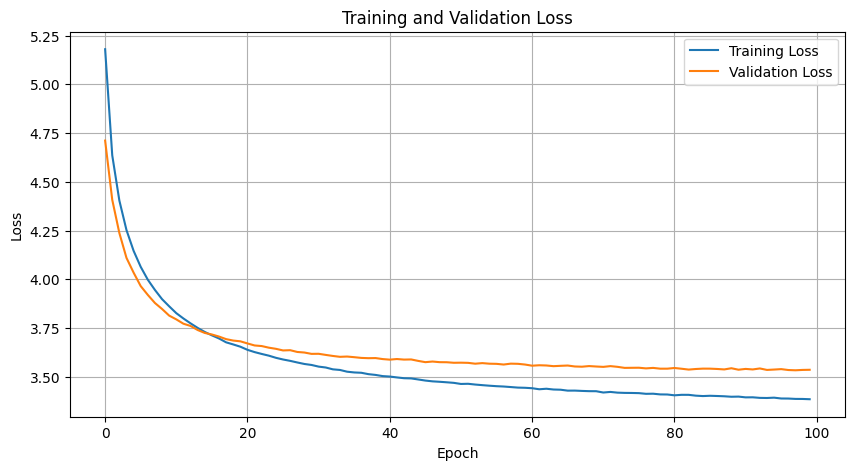

{'love': 0.05944447501529544, 'dark': 0.11677224627224625, 'light': 0.16936492079349222}


In [107]:
dropout = 0.5
sequence_length = 4
batch_size = 64
hidden_size = 256
lr = 0.001
epochs = 100

words_list=["love" , "dark" , "light"]
words_polarity = []

model_hyper = LyricsGeneratorModel(num_of_melody_features=num_of_features_second,
                             vocab_size=vocab_size_second,
                             embedding_dim=embedding_dim_second,
                             embedding_matrix=embedding_matrix_cuda_second,
                             hidden_size=hidden_size,
                             dropout_rate=dropout)

trained_model = train_model(model=model_hyper,
                            df=train_df_second,
                            word_indices_array = word_indices_second,
                            sequence_length=sequence_length,
                            batch_size=batch_size,
                            epochs=epochs,
                            lr=lr)

filename = f"best1_model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}.pth" #TOCHECK IF PT / PTH (what we did in work 2)
torch.save(trained_model.state_dict(), filename)

print(f"Model saved as {filename}")

for i in range(len(preperd_test_second)):
    generated_song = generate_lyrics_from_indices(trained_model, preperd_test_second[i][0], preperd_test_second[i][1], indices_word_second, num_words=int(average_length))
    print(f"-------- test ---------")
    print_nice(generated_song)
    print("    ")

    polarity = []
    
    for word in words_list:
        print(f"-------- {word} ---------")
        generated_song = generate_lyrics_from_indices_single_word(trained_model, word, preperd_test_second[i][1],word_indices_second ,  indices_word_second, num_words=int(average_length))
        print_nice(generated_song)
        print("    ")
        
        polarity_result = analyze_sentiment(generated_song)
        polarity.append(polarity_result)
        
    words_polarity.append(dict(zip(words_list, polarity)))

log_dir = f"model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}"
plot_loss(log_dir)

sums = defaultdict(float)
counts = defaultdict(int)

for d in words_polarity:
    for key, value in d.items():
        sums[key] += value
        counts[key] += 1

averages = {key: sums[key] / counts[key] for key in sums}
print(averages)

## Second Approach

Training on cuda


Epoch 1 - Validation: 100%|██████████| 418/418 [00:00<00:00, 996.78batch/s] 


Epoch 1 completed, Training Loss: 4.399648925466719, Validation Loss: 3.6755609346919083


Epoch 2 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1001.35batch/s]


Epoch 2 completed, Training Loss: 3.866814479767394, Validation Loss: 3.448250063868801


Epoch 3 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1000.04batch/s]


Epoch 3 completed, Training Loss: 3.7286827456371476, Validation Loss: 3.3688003857169995


Epoch 4 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.66batch/s]


Epoch 4 completed, Training Loss: 3.6607606866647022, Validation Loss: 3.31257519995767


Epoch 5 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1000.47batch/s]


Epoch 5 completed, Training Loss: 3.6180471327541746, Validation Loss: 3.2546841082960793


Epoch 6 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.19batch/s]


Epoch 6 completed, Training Loss: 3.5877208164327996, Validation Loss: 3.2177339438616372


Epoch 7 - Validation: 100%|██████████| 418/418 [00:00<00:00, 998.42batch/s] 


Epoch 7 completed, Training Loss: 3.5684536045751916, Validation Loss: 3.2366779033076822


Epoch 8 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1009.60batch/s]


Epoch 8 completed, Training Loss: 3.550036993490465, Validation Loss: 3.21122034143603


Epoch 9 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1000.34batch/s]


Epoch 9 completed, Training Loss: 3.537807234044307, Validation Loss: 3.183892768535888


Epoch 10 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1004.35batch/s]


Epoch 10 completed, Training Loss: 3.524161695073069, Validation Loss: 3.178231719578282


Epoch 11 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.88batch/s]


Epoch 11 completed, Training Loss: 3.5156184761015106, Validation Loss: 3.1724896835938594


Epoch 12 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.82batch/s]


Epoch 12 completed, Training Loss: 3.50842834093606, Validation Loss: 3.1712265208577426


Epoch 13 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1008.57batch/s]


Epoch 13 completed, Training Loss: 3.500202634823499, Validation Loss: 3.164068767898961


Epoch 14 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1007.07batch/s]


Epoch 14 completed, Training Loss: 3.4952712501582335, Validation Loss: 3.1555690833826384


Epoch 15 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1001.33batch/s]


Epoch 15 completed, Training Loss: 3.489037564844208, Validation Loss: 3.1252687462208946


Epoch 16 - Validation: 100%|██████████| 418/418 [00:00<00:00, 995.32batch/s] 


Epoch 16 completed, Training Loss: 3.482801156921064, Validation Loss: 3.1237419028031197


Epoch 17 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1003.54batch/s]


Epoch 17 completed, Training Loss: 3.4763740639353906, Validation Loss: 3.148942341644798


Epoch 18 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.49batch/s]


Epoch 18 completed, Training Loss: 3.475411731849009, Validation Loss: 3.1225284851338877


Epoch 19 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.96batch/s]


Epoch 19 completed, Training Loss: 3.4691495884296506, Validation Loss: 3.129348116628291


Epoch 20 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.39batch/s]


Epoch 20 completed, Training Loss: 3.466582349994974, Validation Loss: 3.11969467498469


Epoch 21 - Validation: 100%|██████████| 418/418 [00:00<00:00, 998.99batch/s] 


Epoch 21 completed, Training Loss: 3.4625205503709724, Validation Loss: 3.111583466735183


Epoch 22 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1009.19batch/s]


Epoch 22 completed, Training Loss: 3.4600625529097706, Validation Loss: 3.107211908084924


Epoch 23 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1007.59batch/s]


Epoch 23 completed, Training Loss: 3.4577169960699425, Validation Loss: 3.11440511354419


Epoch 24 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.82batch/s]


Epoch 24 completed, Training Loss: 3.45313617573228, Validation Loss: 3.086675256062923


Epoch 25 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.70batch/s]


Epoch 25 completed, Training Loss: 3.4520426755223665, Validation Loss: 3.1019600954922764


Epoch 26 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.20batch/s]


Epoch 26 completed, Training Loss: 3.4495011154239323, Validation Loss: 3.10975730362121


Epoch 27 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1004.01batch/s]


Epoch 27 completed, Training Loss: 3.4477847525735736, Validation Loss: 3.0999568250190697


Epoch 28 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.31batch/s]


Epoch 28 completed, Training Loss: 3.446465996304728, Validation Loss: 3.097277465619539


Epoch 29 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1007.25batch/s]


Epoch 29 completed, Training Loss: 3.442441802801088, Validation Loss: 3.086657149940016


Epoch 30 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1000.38batch/s]


Epoch 30 completed, Training Loss: 3.44047966819989, Validation Loss: 3.1046237631847986


Epoch 31 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1007.06batch/s]


Epoch 31 completed, Training Loss: 3.437381617261794, Validation Loss: 3.103811675851995


Epoch 32 - Validation: 100%|██████████| 418/418 [00:00<00:00, 997.13batch/s]


Epoch 32 completed, Training Loss: 3.436166530028458, Validation Loss: 3.09168159448359


Epoch 33 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1008.94batch/s]


Epoch 33 completed, Training Loss: 3.4338405259315863, Validation Loss: 3.090552014597295


Epoch 34 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1004.89batch/s]


Epoch 34 completed, Training Loss: 3.4318461456460128, Validation Loss: 3.087464099865781


Epoch 35 - Validation: 100%|██████████| 418/418 [00:00<00:00, 998.19batch/s] 


Epoch 35 completed, Training Loss: 3.4302228651389512, Validation Loss: 3.086267884838524


Epoch 36 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.60batch/s]


Epoch 36 completed, Training Loss: 3.430443202819179, Validation Loss: 3.067305106295353


Epoch 37 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1001.98batch/s]


Epoch 37 completed, Training Loss: 3.427809512842029, Validation Loss: 3.087719851703735


Epoch 38 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.45batch/s]


Epoch 38 completed, Training Loss: 3.42789313394978, Validation Loss: 3.07977580054525


Epoch 39 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.02batch/s]


Epoch 39 completed, Training Loss: 3.426229746699585, Validation Loss: 3.0742735474873957


Epoch 40 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1004.05batch/s]


Epoch 40 completed, Training Loss: 3.427612597140903, Validation Loss: 3.0889680625148936


Epoch 41 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.98batch/s]


Epoch 41 completed, Training Loss: 3.4243365040793226, Validation Loss: 3.070425631326922


Epoch 42 - Validation: 100%|██████████| 418/418 [00:00<00:00, 999.28batch/s] 


Epoch 42 completed, Training Loss: 3.4243985798091767, Validation Loss: 3.069257742480228


Epoch 43 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.82batch/s]


Epoch 43 completed, Training Loss: 3.423166724743349, Validation Loss: 3.0728296463569387


Epoch 44 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.79batch/s]


Epoch 44 completed, Training Loss: 3.4208618363668752, Validation Loss: 3.0823341328561593


Epoch 45 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1005.64batch/s]


Epoch 45 completed, Training Loss: 3.422256798774445, Validation Loss: 3.065337797671414


Epoch 46 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.75batch/s]


Epoch 46 completed, Training Loss: 3.4191349756390044, Validation Loss: 3.067056366131066


Epoch 47 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1009.70batch/s]


Epoch 47 completed, Training Loss: 3.418759909946369, Validation Loss: 3.074529775592129


Epoch 48 - Validation: 100%|██████████| 418/418 [00:00<00:00, 998.61batch/s] 


Epoch 48 completed, Training Loss: 3.4173458762703186, Validation Loss: 3.069001590235952


Epoch 49 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1007.48batch/s]


Epoch 49 completed, Training Loss: 3.4171091065598342, Validation Loss: 3.0692629380659624


Epoch 50 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1004.05batch/s]


Epoch 50 completed, Training Loss: 3.4148011238832052, Validation Loss: 3.066758227120176


Epoch 51 - Validation: 100%|██████████| 418/418 [00:00<00:00, 997.27batch/s] 


Epoch 51 completed, Training Loss: 3.413116266460298, Validation Loss: 3.0588964999577644


Epoch 52 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1010.28batch/s]


Epoch 52 completed, Training Loss: 3.414958023571313, Validation Loss: 3.0682611499676864


Epoch 53 - Validation: 100%|██████████| 418/418 [00:00<00:00, 997.23batch/s]


Epoch 53 completed, Training Loss: 3.4145082529201063, Validation Loss: 3.068165052450445


Epoch 54 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1004.90batch/s]


Epoch 54 completed, Training Loss: 3.414058809804614, Validation Loss: 3.0725456772808823


Epoch 55 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.27batch/s]


Epoch 55 completed, Training Loss: 3.4098715959593306, Validation Loss: 3.065188176894302


Epoch 56 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.91batch/s]


Epoch 56 completed, Training Loss: 3.4107842589533606, Validation Loss: 3.048187810838508


Epoch 57 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1003.65batch/s]


Epoch 57 completed, Training Loss: 3.4091003160900093, Validation Loss: 3.076216465548465


Epoch 58 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1001.91batch/s]


Epoch 58 completed, Training Loss: 3.4085519669675928, Validation Loss: 3.0468412369632265


Epoch 59 - Validation: 100%|██████████| 418/418 [00:00<00:00, 998.62batch/s] 


Epoch 59 completed, Training Loss: 3.409984979165785, Validation Loss: 3.054720941913185


Epoch 60 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1008.01batch/s]


Epoch 60 completed, Training Loss: 3.406479745485818, Validation Loss: 3.0713491120406884


Epoch 61 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.35batch/s]


Epoch 61 completed, Training Loss: 3.407033143940738, Validation Loss: 3.048414306777516


Epoch 62 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1000.73batch/s]


Epoch 62 completed, Training Loss: 3.4045132662226734, Validation Loss: 3.054736499010661


Epoch 63 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1002.72batch/s]


Epoch 63 completed, Training Loss: 3.405050916349157, Validation Loss: 3.0527908596695896


Epoch 64 - Validation: 100%|██████████| 418/418 [00:00<00:00, 995.34batch/s]


Epoch 64 completed, Training Loss: 3.4016200050491108, Validation Loss: 3.049552503955421


Epoch 65 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1010.96batch/s]


Epoch 65 completed, Training Loss: 3.405188336987324, Validation Loss: 3.0665626999293787


Epoch 66 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1006.45batch/s]


Epoch 66 completed, Training Loss: 3.4040701229022874, Validation Loss: 3.068521126605677


Epoch 67 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1003.85batch/s]


Epoch 67 completed, Training Loss: 3.4027110616954133, Validation Loss: 3.0477056423442788


Epoch 68 - Validation: 100%|██████████| 418/418 [00:00<00:00, 1008.78batch/s]


Epoch 68 completed, Training Loss: 3.4038395506635024, Validation Loss: 3.058491744493183
Validation loss hasn't improved for 10 epochs. Stopping early.
Finished Training
Model saved as best2_model_d_0.5_sq_10_bs_64_hs_256_lr_0.01.pth
-------- test ---------
close to me fuss wow so
i lie fuss bo fuss i
remember the sacred lady fuss jerry
started fuss dort in san jose
fuss physically think he knows i
did fuss chung fuss will her
got too fuss they all with
a simple i season fuss my
heart was torn to tell fuss
i give the rum pum fuss
the courtyard follow the sirens fuss
when they move their lips fuss
just tell me and my way
will were closer fuss youre not
a thing thats got fuss gonna
take a greyhound on a pose
and a shadow of view fuss
wastin now its just fuss oh
time on the street fuss and
we question it shows forbid fuss
a super trouper fuss til ive
got so i know fuss if
you got sunday in brooklyn government
fuss no more while you consider
if i never tell me fuss
we can find routine wha

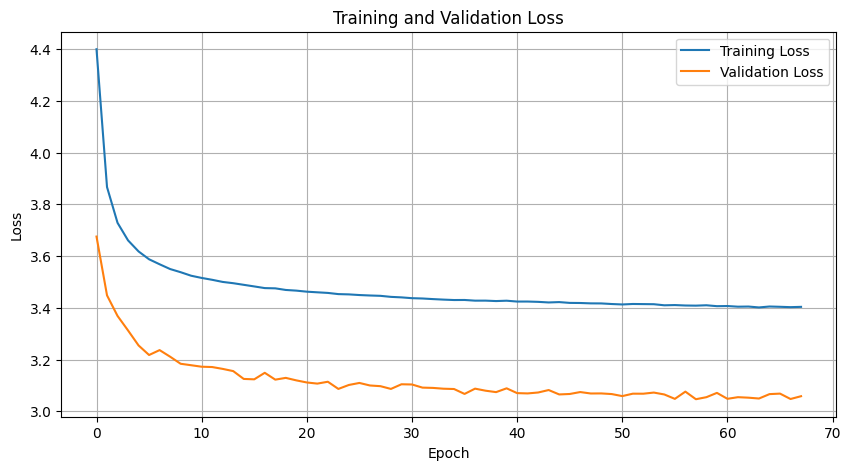

{'love': 0.10521042150024992, 'dark': 0.015131893939393931, 'light': 0.16587343439059127}


In [108]:
dropout = 0.5
sequence_length = 10
batch_size = 64
hidden_size = 256
lr = 0.01
epochs = 100

words_list=["love" , "dark" , "light"]
words_polarity = []

model_hyper = LyricsGeneratorModel(num_of_melody_features=num_of_features_second,
                             vocab_size=vocab_size_second,
                             embedding_dim=embedding_dim_second,
                             embedding_matrix=embedding_matrix_cuda_second,
                             hidden_size=hidden_size,
                             dropout_rate=dropout)

trained_model = train_model(model=model_hyper,
                            df=train_df_second,
                            word_indices_array = word_indices_second,
                            sequence_length=sequence_length,
                            batch_size=batch_size,
                            epochs=epochs,
                            lr=lr)

filename = f"best2_model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}.pth" #TOCHECK IF PT / PTH (what we did in work 2)
torch.save(trained_model.state_dict(), filename)

print(f"Model saved as {filename}")

for i in range(len(preperd_test_second)):
    generated_song = generate_lyrics_from_indices(trained_model, preperd_test_second[i][0], preperd_test_second[i][1], indices_word_second, num_words=int(average_length))
    print(f"-------- test ---------")
    print_nice(generated_song)
    print("    ")

    polarity = []
    
    for word in words_list:
        print(f"-------- {word} ---------")
        generated_song = generate_lyrics_from_indices_single_word(trained_model, word, preperd_test_second[i][1],word_indices_second ,  indices_word_second, num_words=int(average_length))
        print_nice(generated_song)
        print("    ")
        
        polarity_result = analyze_sentiment(generated_song)
        polarity.append(polarity_result)
        
    words_polarity.append(dict(zip(words_list, polarity)))

log_dir = f"model_d_{dropout}_sq_{sequence_length}_bs_{batch_size}_hs_{hidden_size}_lr_{lr}"
plot_loss(log_dir)

sums = defaultdict(float)
counts = defaultdict(int)

for d in words_polarity:
    for key, value in d.items():
        sums[key] += value
        counts[key] += 1

averages = {key: sums[key] / counts[key] for key in sums}
print(averages)